In [1]:
#!pip install keras
#!pip install numpy
#!pip install imageio
#!pip install matplotlib
#!pip install opencv-python

import threading
import sys
import cv2
import sys
import os
import csv
import itertools
import numpy as np
from PIL import Image
import imageio
import itertools as it
import tensorflow as tf
import keras
print("Keras version %s" % keras.__version__)
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K

print("Tensorflow version %s" % tf.__version__)

import pprint
pp = pprint.PrettyPrinter(depth=6)

Using TensorFlow backend.


Keras version 2.0.4
Tensorflow version 1.1.0


In [2]:
# Add the standard include path for FoosMetrics
sys.path.insert(0, './../../Code')

import importlib
import process
importlib.reload(process)

<module 'process' from './../../Code\\process.py'>

In [3]:
# Load the data and frames, and add the normalizer
training = process.Processor("data_loader_training.json")
validation = process.Processor("data_loader_validation.json")
output_names = ["g1","d1","o1","f1","f2","o2","d2","g2","-2"]

Creating transform: random_video_loader
Adding folder '.\..\..\Data\Processed\BallTracking\Training\'
'.\..\..\Data\Processed\BallTracking\Training\balltracking_0.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_1.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_10.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_11.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_12.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_13.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_14.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_15.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_16.avi': 10000 frames found.
'.\..\..\Data\Processed\BallTracking\Training\balltracking_17.avi': 10000 frames found.
'.\..\..\Data\Proces

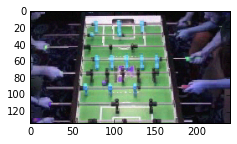

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


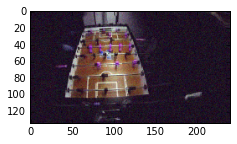

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


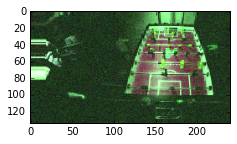

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


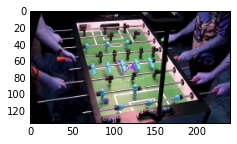

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


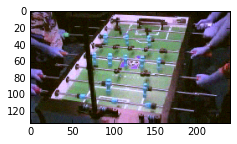

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


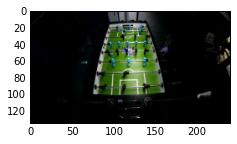

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


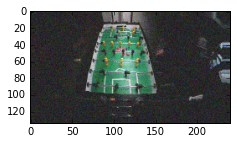

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


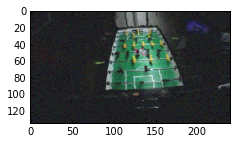

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


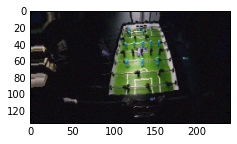

array([[ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])


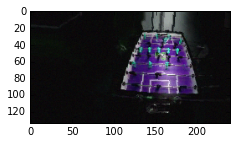

array([[ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]])


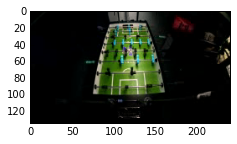

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


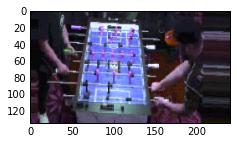

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


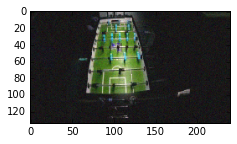

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


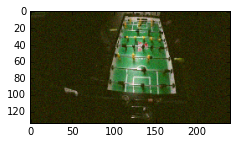

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


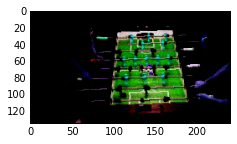

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


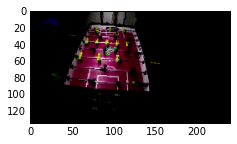

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


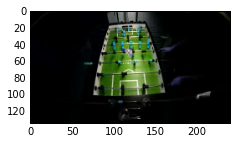

array([[ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])


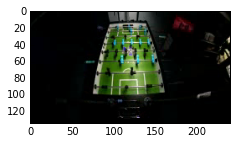

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]])


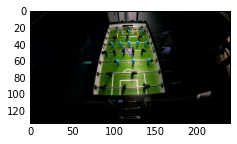

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])


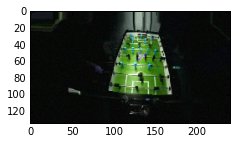

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]])


In [4]:
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# View the first few frames
for k in range(20):
    data = training.get_next_frame()
    frame = data["frame"]
    fig, ax = plt.subplots(figsize=(18, 2))
    plt.imshow(frame)
    plt.show()
    pp.pprint( np.transpose( np.array(data["values"] ) ))

In [5]:
# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
class threadsafe_iter(object):
  """
    Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
  def __init__(self, it):
      self.it = it
      self.lock = threading.Lock()

  def __iter__(self):
      return self

  def __next__(self):
      with self.lock:
          return self.it.__next__()

# https://stanford.edu/~shervine/blog/keras-generator-multiprocessing.html
def threadsafe_generator(f):
  """
    A decorator that takes a generator function and makes it thread-safe.
    """
  def g(*a, **kw):
      return threadsafe_iter(f(*a, **kw))
  return g


# Define our training and validation iterators
@threadsafe_generator
def TrainGen(training):
    while True:
        data = training.get_next_frame()
        if data is not None:
            frame = data["frame"]
            output = np.array(data["values"])

            while frame is not None:
                yield (frame, output)
                data = training.get_next_frame()
                if data is not None:
                    frame = data["frame"]
                    output = np.array(data["values"])
                else:
                    frame = None
                
             
# Generators for training the position
@threadsafe_generator
def TrainBatchGen(batch_size, training):
    gen = TrainGen(training)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")

                
             
# Generators for training the position
@threadsafe_generator
def ValidationBatchGen(batch_size, validation):
    gen = TrainGen(validation)
    while True:
        # Build the next batch
        batch_frames = np.zeros(shape=(batch_size, 134, 240, 3), dtype=np.float32)
        batch_outputs = np.zeros(shape=(batch_size, 9), dtype=np.float32)
        for i in range(batch_size):
            (frame, output) = next(gen)
            batch_frames[i,:,:,:] = frame
            batch_outputs[i,:] = output[:,0]
            
        
        #pp.pprint("Yielding batch")
        #pp.pprint(batch_outputs)
        yield (batch_frames, batch_outputs)
        #pp.pprint("Yielded batch")
        
    
    
        
    


In [6]:
# Utilities for plotting the result and training
def plot_validate(generator, model, count, name, output_names):   
    outputs_predicted = None
    outputs_true = None
    
    while outputs_predicted is None or outputs_predicted.shape[0] < count:
        
        (new_frames, new_outputs_true) = next(generator)
        if outputs_true is None:
            outputs_true = new_outputs_true
        else:
            outputs_true = np.concatenate( (outputs_true, new_outputs_true), axis=0 )
        
        
        new_outputs_predicted = model.predict(new_frames, batch_size=new_frames.shape[0], verbose=0)
        if outputs_predicted is None:
            outputs_predicted = new_outputs_predicted
        else:
            outputs_predicted = np.concatenate( (outputs_predicted, new_outputs_predicted), axis=0 )
    
    
    f, axes = plt.subplots(outputs_true.shape[1], figsize=(12, 12), sharex=True, sharey=True)
    
    for i in range(outputs_true.shape[1]):
        true, predicted = zip(*sorted(zip(outputs_true[0:count,i], outputs_predicted[0:count,i])))
        axes[i].plot(range(count),true, label="True position" )
        axes[i].plot(range(count),predicted, label="Predicted position" )
        axes[i].grid(False)
        axes[i].set_ylabel(output_names[i])
        if i == 0:
            axes[i].legend()
            axes[i].set_title(name)
            
    
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    
    
    plt.show()

    
    



In [7]:
from keras.models import Sequential
from keras.layers import *
from keras.models import Model



image_height       = 134
image_width        = 240
image_channels     = 3

# Model options
batch_size = 10
lstm_output_size = 300
cnn_kernel_count = 40

# Build the model
pp.pprint("Input shape without batches:")
pp.pprint((image_height, image_width, image_channels))

# Used to give fixed names to the layers for transferring the model
conv_num = 0 
pool_num = 0
dense_num = 0

'''
# Build a functional model design
inputs = Input(shape=(image_height, image_width, image_channels,),
              name="Input")
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(inputs)
conv_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "conv2d_%i"%conv_num)(x)
conv_num+=1

# Split into a horizontal detail and vertical detailed CNN paths
x = MaxPooling2D( pool_size=(1, 2),
                  name = "max_pooling2d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1

x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = MaxPooling2D( pool_size=(2, 2),
                  name = "max_pooling3d_%i"%pool_num)(x) # (?, 1, 54, 100, 128, 3 )
pool_num+=1

x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1
x = Conv2D(cnn_kernel_count,
           kernel_size = (3, 3),
           padding = "same",
           activation = "relu",
           name = "Conv2D_%i"%conv_num)(x)
conv_num+=1


#x = Flatten()(x)
#x = Reshape((number_of_frames,6*6*cnn_kernel_count))(x)
x = Flatten()(x)


x = Dense(128, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
x = Dense(64, activation='relu',name="dense_%i"%dense_num)(x)
dense_num+=1
x = Dropout(0.5)(x)
predictions = Dense(9, activation='softmax',name="dense_%i"%dense_num)(x)
dense_num+=1

model = Model(inputs=inputs, outputs=predictions)
'''

# create the base pre-trained model
base_model = keras.applications.xception.Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=9)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# let's add fully-connected layers
#x = Dense(512, activation='relu')(x)
#x = Dense(128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(9, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])


model.summary()

# Train the model to predict the future position. This is the control signal to the robot AI
WEIGHTS_FNAME = '.\\Goalie3Frames\\weights_%i.hdf'
MODELS_FNAME = '.\\Goalie3Frames\\models_%i.h5'

'Input shape without batches:'
(134, 240, 3)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
block1_conv1 (Conv2D)            (None, None, None, 32 864         input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv1_bn (BatchNormalizat (None, None, None, 32 128         block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_conv1_act (Activation)    (None, None, None, 32 0           block1_conv1_bn[0][0]            
______________________________________________

Batch size 5: 175 training batches, 152 validation batches
Epoch 1/1
176/175 [==============================] - 87s - loss: 2.0439 - categorical_accuracy: 0.2125 - val_loss: 2.0310 - val_categorical_accuracy: 0.2183


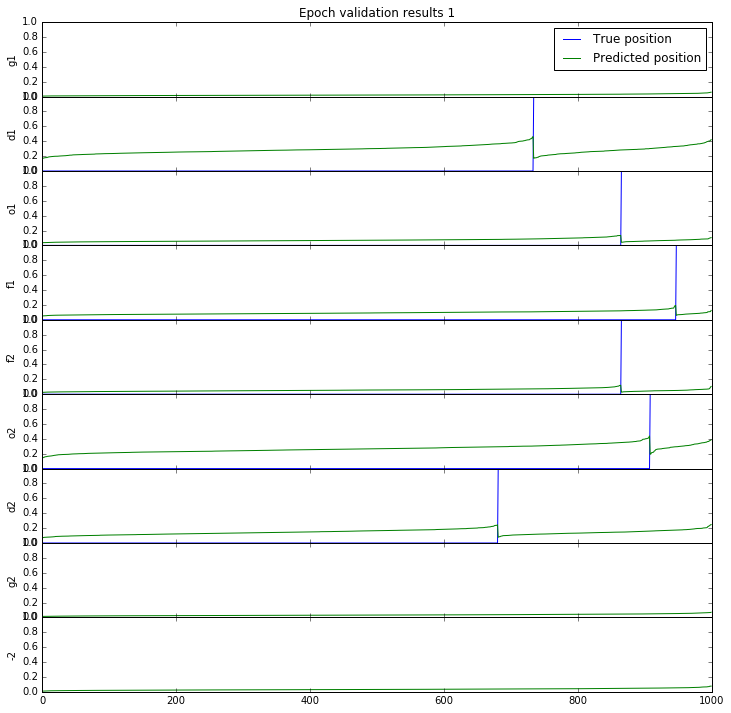

Wrote model to .\Models\weights_1.hdf
Epoch 2/2
176/175 [==============================] - 63s - loss: 1.8315 - categorical_accuracy: 0.3000 - val_loss: 1.9411 - val_categorical_accuracy: 0.1085
Wrote model to .\Models\weights_2.hdf
Epoch 3/3
176/175 [==============================] - 63s - loss: 1.7673 - categorical_accuracy: 0.3273 - val_loss: 1.9134 - val_categorical_accuracy: 0.1386
Wrote model to .\Models\weights_3.hdf
Epoch 4/4
176/175 [==============================] - 64s - loss: 1.6450 - categorical_accuracy: 0.3705 - val_loss: 1.9000 - val_categorical_accuracy: 0.1150
Wrote model to .\Models\weights_4.hdf
Epoch 5/5
176/175 [==============================] - 64s - loss: 1.5994 - categorical_accuracy: 0.3909 - val_loss: 2.0606 - val_categorical_accuracy: 0.1477
Wrote model to .\Models\weights_5.hdf
Epoch 6/6
176/175 [==============================] - 63s - loss: 1.4805 - categorical_accuracy: 0.4182 - val_loss: 1.9925 - val_categorical_accuracy: 0.1163
Wrote model to .\Models\w

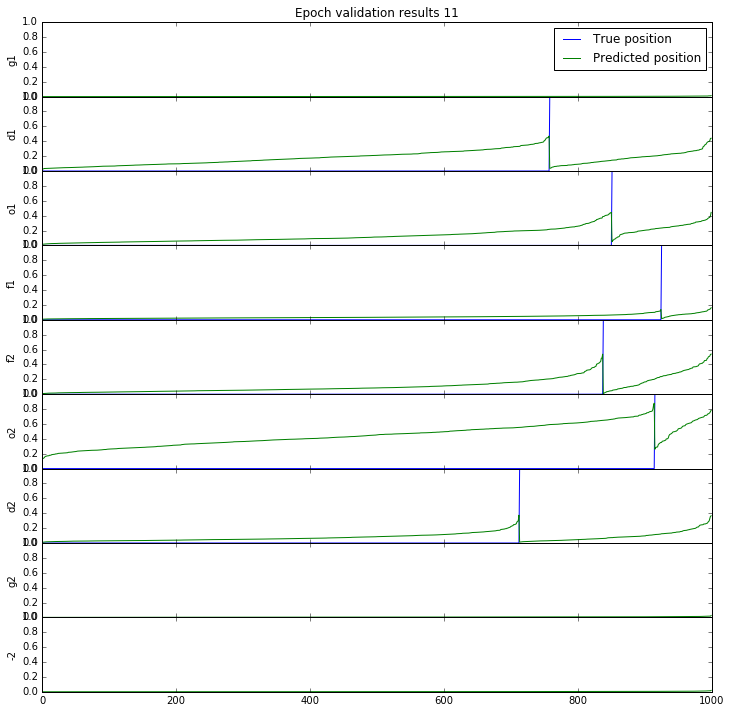

Wrote model to .\Models\weights_11.hdf
Epoch 12/12
176/175 [==============================] - 63s - loss: 1.1531 - categorical_accuracy: 0.5875 - val_loss: 1.8063 - val_categorical_accuracy: 0.2536
Wrote model to .\Models\weights_12.hdf
Epoch 13/13
176/175 [==============================] - 63s - loss: 1.1511 - categorical_accuracy: 0.5898 - val_loss: 1.7843 - val_categorical_accuracy: 0.2732
Wrote model to .\Models\weights_13.hdf
Epoch 14/14
176/175 [==============================] - 63s - loss: 1.1313 - categorical_accuracy: 0.5818 - val_loss: 1.9152 - val_categorical_accuracy: 0.2693
Wrote model to .\Models\weights_14.hdf
Epoch 15/15
176/175 [==============================] - 63s - loss: 1.0864 - categorical_accuracy: 0.5966 - val_loss: 1.8582 - val_categorical_accuracy: 0.2170
Wrote model to .\Models\weights_15.hdf
Epoch 16/16
176/175 [==============================] - 63s - loss: 1.0434 - categorical_accuracy: 0.6352 - val_loss: 1.7373 - val_categorical_accuracy: 0.2863
Wrote mode

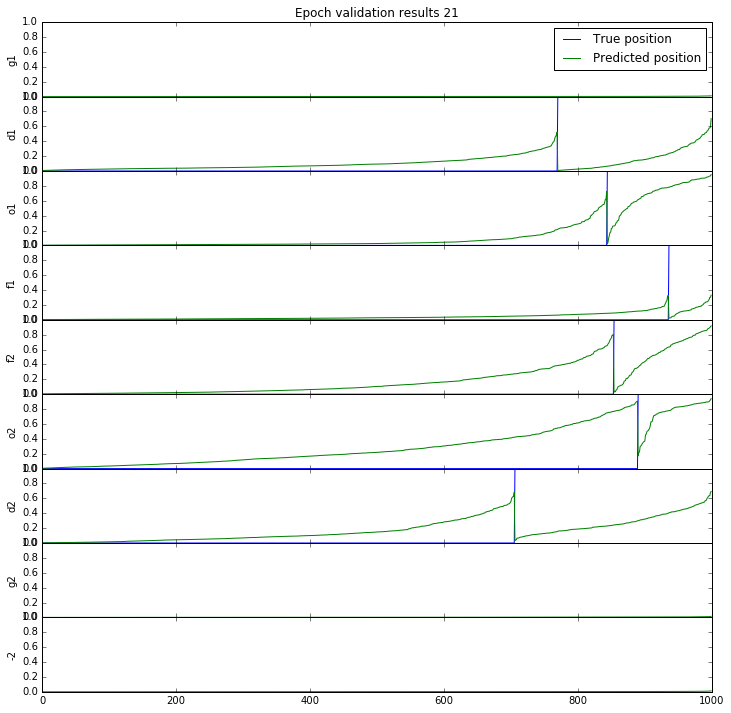

Wrote model to .\Models\weights_21.hdf
Epoch 22/22
176/175 [==============================] - 63s - loss: 0.8534 - categorical_accuracy: 0.6943 - val_loss: 1.3668 - val_categorical_accuracy: 0.4301
Wrote model to .\Models\weights_22.hdf
Epoch 23/23
176/175 [==============================] - 77s - loss: 0.8195 - categorical_accuracy: 0.7216 - val_loss: 1.2120 - val_categorical_accuracy: 0.5176
Wrote model to .\Models\weights_23.hdf
Epoch 24/24
176/175 [==============================] - 63s - loss: 0.7993 - categorical_accuracy: 0.7136 - val_loss: 1.1291 - val_categorical_accuracy: 0.5686
Wrote model to .\Models\weights_24.hdf
Epoch 25/25
176/175 [==============================] - 63s - loss: 0.8034 - categorical_accuracy: 0.7227 - val_loss: 1.2297 - val_categorical_accuracy: 0.4797
Wrote model to .\Models\weights_25.hdf
Epoch 26/26
176/175 [==============================] - 64s - loss: 0.7741 - categorical_accuracy: 0.7398 - val_loss: 1.2860 - val_categorical_accuracy: 0.4810
Wrote mode

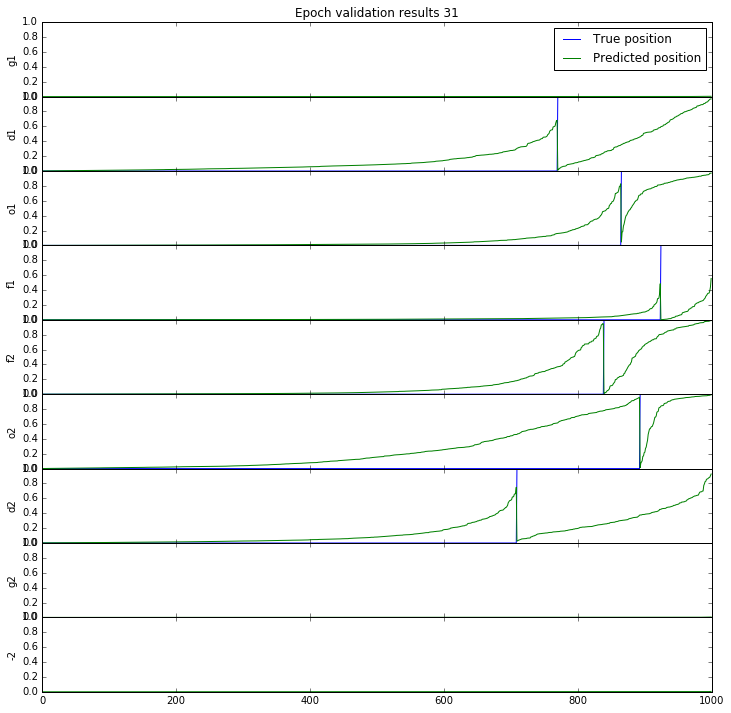

Wrote model to .\Models\weights_31.hdf
Epoch 32/32
176/175 [==============================] - 63s - loss: 0.6043 - categorical_accuracy: 0.7955 - val_loss: 0.8206 - val_categorical_accuracy: 0.6824
Wrote model to .\Models\weights_32.hdf
Epoch 33/33
176/175 [==============================] - 63s - loss: 0.6968 - categorical_accuracy: 0.7773 - val_loss: 1.0757 - val_categorical_accuracy: 0.5268
Wrote model to .\Models\weights_33.hdf
Epoch 34/34
176/175 [==============================] - 63s - loss: 0.6385 - categorical_accuracy: 0.7886 - val_loss: 1.0132 - val_categorical_accuracy: 0.6366
Wrote model to .\Models\weights_34.hdf
Epoch 35/35
176/175 [==============================] - 63s - loss: 0.6726 - categorical_accuracy: 0.7886 - val_loss: 0.9034 - val_categorical_accuracy: 0.6105
Wrote model to .\Models\weights_35.hdf
Epoch 36/36
176/175 [==============================] - 63s - loss: 0.6324 - categorical_accuracy: 0.7977 - val_loss: 1.1198 - val_categorical_accuracy: 0.5268
Wrote mode

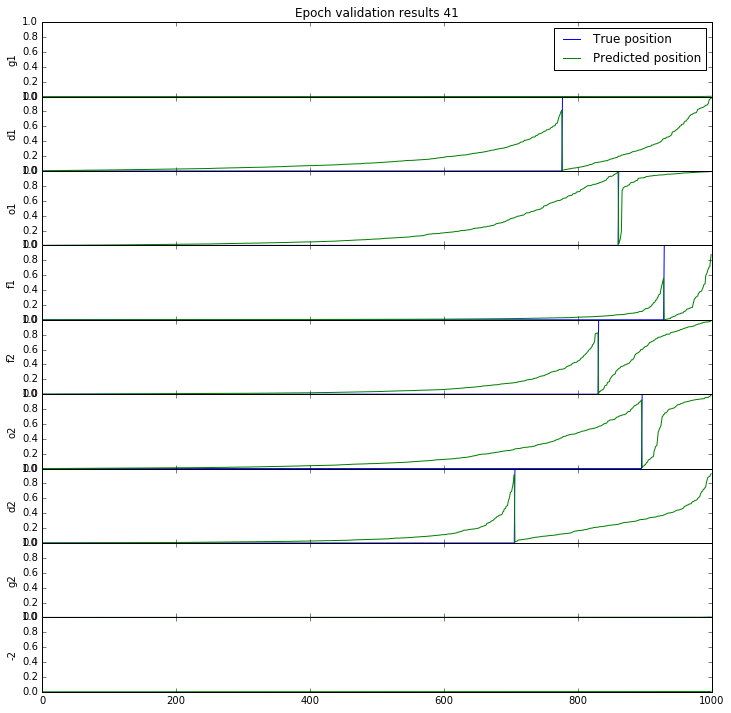

Wrote model to .\Models\weights_41.hdf
Epoch 42/42
176/175 [==============================] - 63s - loss: 0.5076 - categorical_accuracy: 0.8227 - val_loss: 1.1454 - val_categorical_accuracy: 0.5412
Wrote model to .\Models\weights_42.hdf
Epoch 43/43
176/175 [==============================] - 63s - loss: 0.5240 - categorical_accuracy: 0.8114 - val_loss: 1.1580 - val_categorical_accuracy: 0.5699
Wrote model to .\Models\weights_43.hdf
Epoch 44/44
176/175 [==============================] - 63s - loss: 0.5204 - categorical_accuracy: 0.8352 - val_loss: 0.8969 - val_categorical_accuracy: 0.6601
Wrote model to .\Models\weights_44.hdf
Epoch 45/45
176/175 [==============================] - 63s - loss: 0.5373 - categorical_accuracy: 0.8250 - val_loss: 1.0718 - val_categorical_accuracy: 0.5686
Wrote model to .\Models\weights_45.hdf
Epoch 46/46
176/175 [==============================] - 63s - loss: 0.5263 - categorical_accuracy: 0.8170 - val_loss: 0.9752 - val_categorical_accuracy: 0.6693
Wrote mode

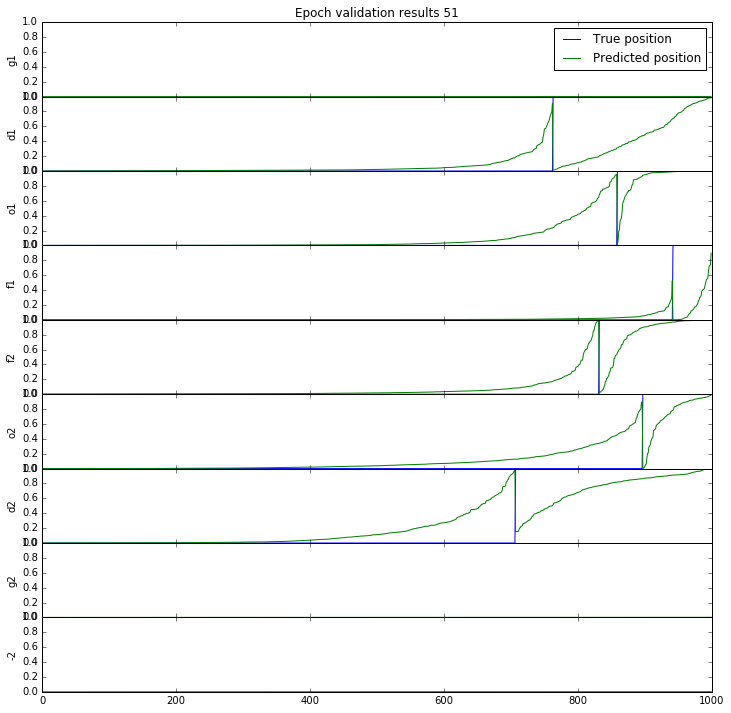

Wrote model to .\Models\weights_51.hdf
Epoch 52/52
176/175 [==============================] - 63s - loss: 0.4448 - categorical_accuracy: 0.8545 - val_loss: 0.7682 - val_categorical_accuracy: 0.7216
Wrote model to .\Models\weights_52.hdf
Epoch 53/53
176/175 [==============================] - 63s - loss: 0.4361 - categorical_accuracy: 0.8534 - val_loss: 0.6369 - val_categorical_accuracy: 0.7856
Wrote model to .\Models\weights_53.hdf
Epoch 54/54
176/175 [==============================] - 63s - loss: 0.4434 - categorical_accuracy: 0.8591 - val_loss: 0.7708 - val_categorical_accuracy: 0.7190
Wrote model to .\Models\weights_54.hdf
Epoch 55/55
176/175 [==============================] - 63s - loss: 0.4526 - categorical_accuracy: 0.8636 - val_loss: 0.8120 - val_categorical_accuracy: 0.7111
Wrote model to .\Models\weights_55.hdf
Epoch 56/56
176/175 [==============================] - 63s - loss: 0.4302 - categorical_accuracy: 0.8489 - val_loss: 0.6533 - val_categorical_accuracy: 0.7569
Wrote mode

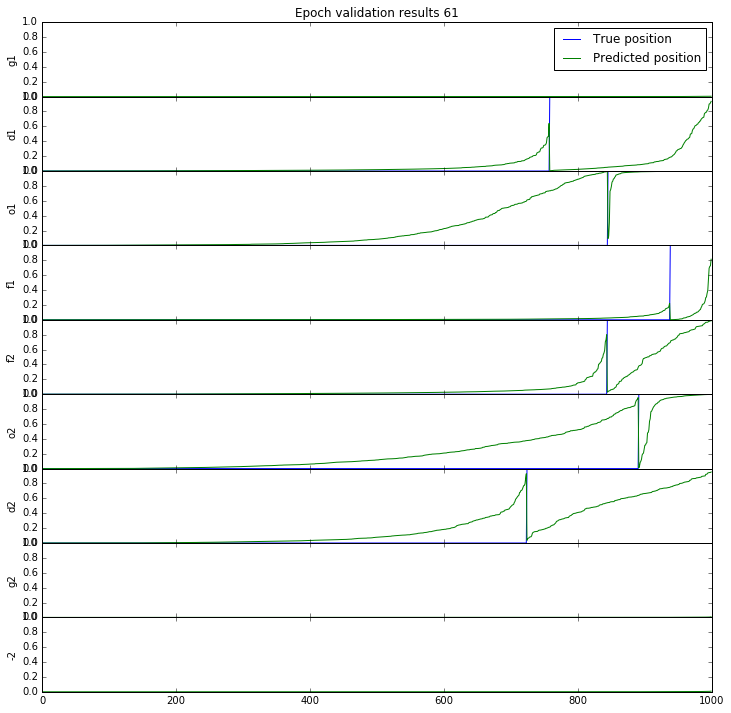

Wrote model to .\Models\weights_61.hdf
Epoch 62/62
176/175 [==============================] - 63s - loss: 0.3423 - categorical_accuracy: 0.8841 - val_loss: 1.0439 - val_categorical_accuracy: 0.6275
Wrote model to .\Models\weights_62.hdf
Epoch 63/63
176/175 [==============================] - 63s - loss: 0.3506 - categorical_accuracy: 0.8955 - val_loss: 1.0508 - val_categorical_accuracy: 0.6418
Wrote model to .\Models\weights_63.hdf
Epoch 64/64
176/175 [==============================] - 63s - loss: 0.3677 - categorical_accuracy: 0.8852 - val_loss: 1.0559 - val_categorical_accuracy: 0.6248
Wrote model to .\Models\weights_64.hdf
Epoch 65/65
176/175 [==============================] - 63s - loss: 0.3610 - categorical_accuracy: 0.8818 - val_loss: 1.0663 - val_categorical_accuracy: 0.6405
Wrote model to .\Models\weights_65.hdf
Epoch 66/66
176/175 [==============================] - 63s - loss: 0.3707 - categorical_accuracy: 0.8852 - val_loss: 1.1148 - val_categorical_accuracy: 0.6444
Wrote mode

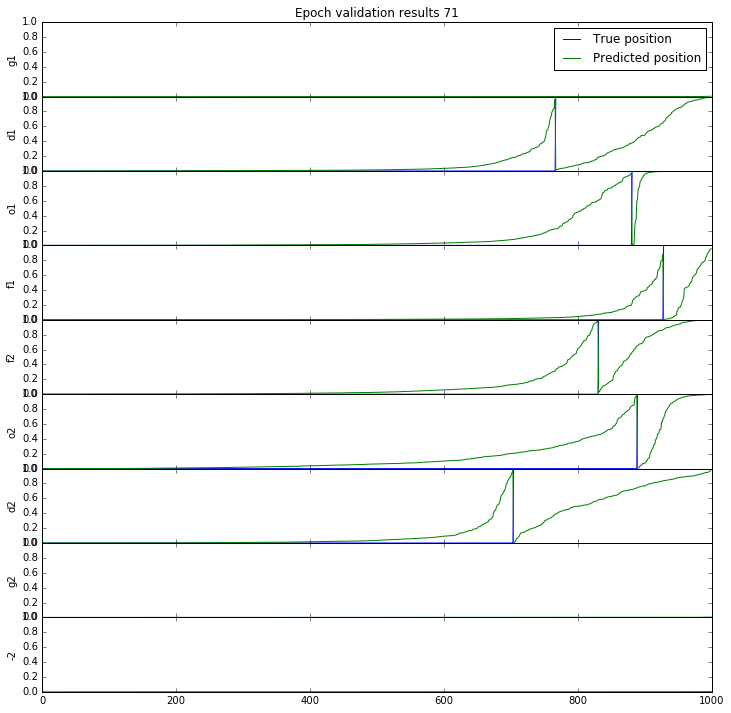

Wrote model to .\Models\weights_71.hdf
Epoch 72/72
176/175 [==============================] - 63s - loss: 0.3936 - categorical_accuracy: 0.8693 - val_loss: 0.9780 - val_categorical_accuracy: 0.6431
Wrote model to .\Models\weights_72.hdf
Epoch 73/73
176/175 [==============================] - 63s - loss: 0.3369 - categorical_accuracy: 0.8966 - val_loss: 0.8034 - val_categorical_accuracy: 0.7072
Wrote model to .\Models\weights_73.hdf
Epoch 74/74
176/175 [==============================] - 63s - loss: 0.3801 - categorical_accuracy: 0.8739 - val_loss: 1.2093 - val_categorical_accuracy: 0.6092
Wrote model to .\Models\weights_74.hdf
Epoch 75/75
176/175 [==============================] - 63s - loss: 0.3260 - categorical_accuracy: 0.8977 - val_loss: 0.9632 - val_categorical_accuracy: 0.6549
Wrote model to .\Models\weights_75.hdf
Epoch 76/76
176/175 [==============================] - 63s - loss: 0.2743 - categorical_accuracy: 0.9068 - val_loss: 0.9180 - val_categorical_accuracy: 0.6575
Wrote mode

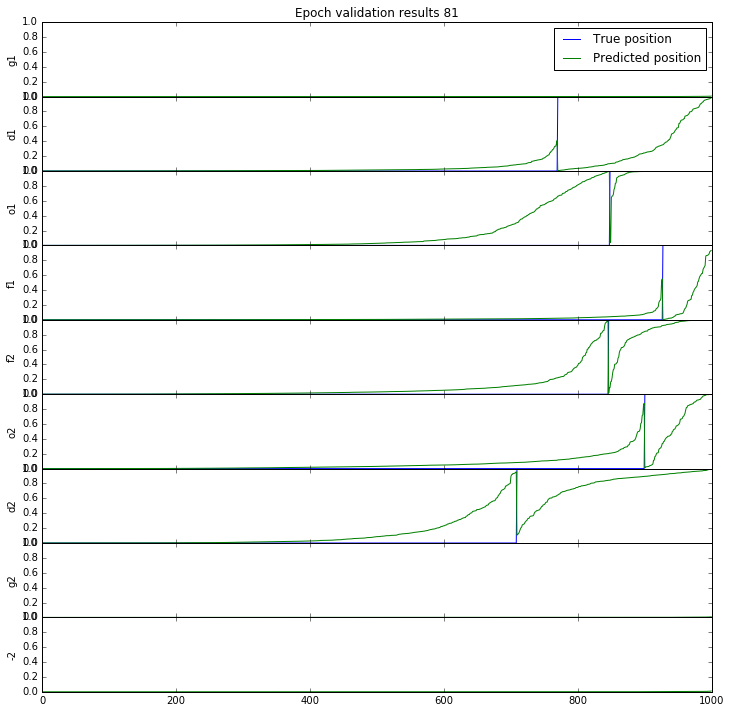

Wrote model to .\Models\weights_81.hdf
Epoch 82/82
176/175 [==============================] - 63s - loss: 0.2958 - categorical_accuracy: 0.8943 - val_loss: 1.1340 - val_categorical_accuracy: 0.6209
Wrote model to .\Models\weights_82.hdf
Epoch 83/83
176/175 [==============================] - 63s - loss: 0.2953 - categorical_accuracy: 0.9102 - val_loss: 0.7711 - val_categorical_accuracy: 0.7098
Wrote model to .\Models\weights_83.hdf
Epoch 84/84
176/175 [==============================] - 63s - loss: 0.3235 - categorical_accuracy: 0.8955 - val_loss: 1.0030 - val_categorical_accuracy: 0.7098
Wrote model to .\Models\weights_84.hdf
Epoch 85/85
176/175 [==============================] - 63s - loss: 0.2821 - categorical_accuracy: 0.9023 - val_loss: 0.7693 - val_categorical_accuracy: 0.7412
Wrote model to .\Models\weights_85.hdf
Epoch 86/86
176/175 [==============================] - 63s - loss: 0.3058 - categorical_accuracy: 0.8977 - val_loss: 1.2195 - val_categorical_accuracy: 0.6484
Wrote mode

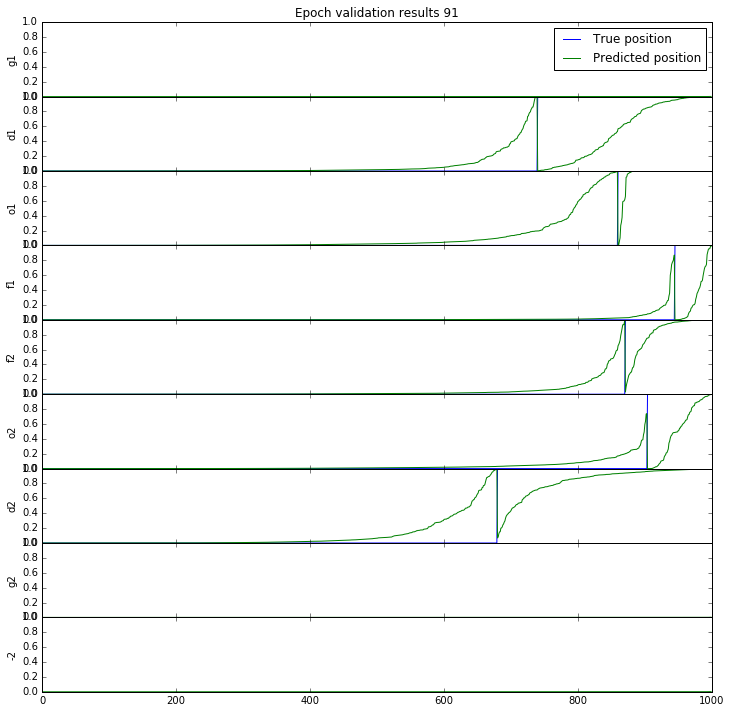

Wrote model to .\Models\weights_91.hdf
Epoch 92/92
176/175 [==============================] - 64s - loss: 0.2275 - categorical_accuracy: 0.9193 - val_loss: 1.3886 - val_categorical_accuracy: 0.6340
Wrote model to .\Models\weights_92.hdf
Epoch 93/93
176/175 [==============================] - 63s - loss: 0.3105 - categorical_accuracy: 0.8943 - val_loss: 1.3253 - val_categorical_accuracy: 0.6471
Wrote model to .\Models\weights_93.hdf
Epoch 94/94
176/175 [==============================] - 63s - loss: 0.3011 - categorical_accuracy: 0.9034 - val_loss: 1.0076 - val_categorical_accuracy: 0.7320
Wrote model to .\Models\weights_94.hdf
Epoch 95/95
176/175 [==============================] - 63s - loss: 0.2702 - categorical_accuracy: 0.9068 - val_loss: 0.8900 - val_categorical_accuracy: 0.6967
Wrote model to .\Models\weights_95.hdf
Epoch 96/96
176/175 [==============================] - 63s - loss: 0.2895 - categorical_accuracy: 0.9148 - val_loss: 1.2829 - val_categorical_accuracy: 0.6562
Wrote mode

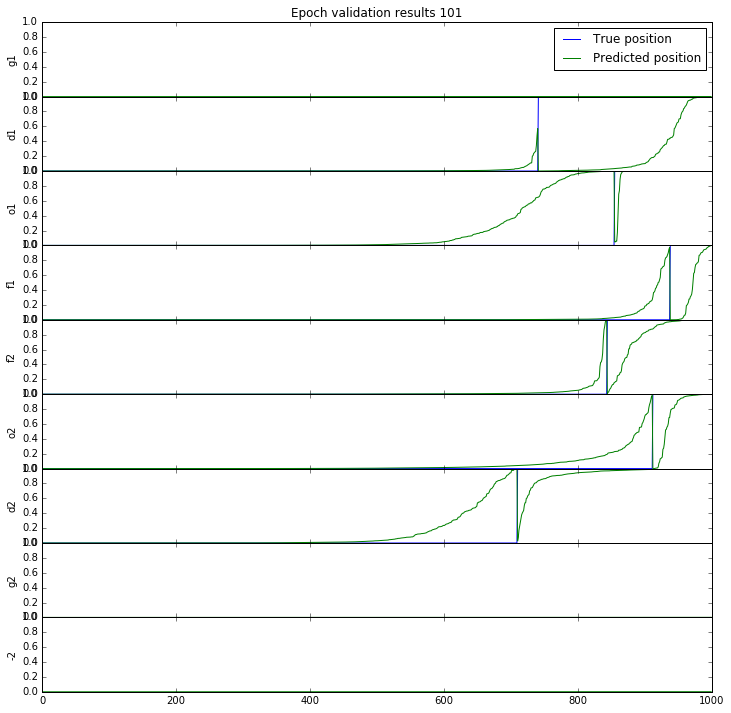

Wrote model to .\Models\weights_101.hdf
Epoch 102/102
176/175 [==============================] - 63s - loss: 0.2530 - categorical_accuracy: 0.9170 - val_loss: 1.1983 - val_categorical_accuracy: 0.6732
Wrote model to .\Models\weights_102.hdf
Epoch 103/103
176/175 [==============================] - 63s - loss: 0.2216 - categorical_accuracy: 0.9239 - val_loss: 1.2233 - val_categorical_accuracy: 0.6902
Wrote model to .\Models\weights_103.hdf
Epoch 104/104
176/175 [==============================] - 63s - loss: 0.2609 - categorical_accuracy: 0.9170 - val_loss: 0.8419 - val_categorical_accuracy: 0.7556
Wrote model to .\Models\weights_104.hdf
Epoch 105/105
176/175 [==============================] - 63s - loss: 0.2621 - categorical_accuracy: 0.9102 - val_loss: 0.7136 - val_categorical_accuracy: 0.7660
Wrote model to .\Models\weights_105.hdf
Epoch 106/106
176/175 [==============================] - 63s - loss: 0.2311 - categorical_accuracy: 0.9261 - val_loss: 1.0897 - val_categorical_accuracy: 0.

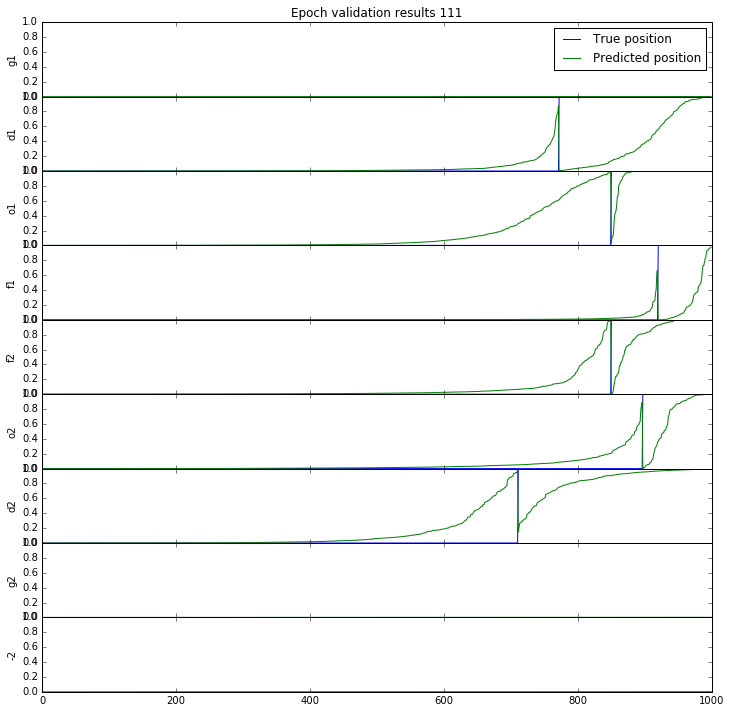

Wrote model to .\Models\weights_111.hdf
Epoch 112/112
176/175 [==============================] - 63s - loss: 0.2099 - categorical_accuracy: 0.9261 - val_loss: 0.9601 - val_categorical_accuracy: 0.7203
Wrote model to .\Models\weights_112.hdf
Epoch 113/113
176/175 [==============================] - 63s - loss: 0.1925 - categorical_accuracy: 0.9330 - val_loss: 0.7749 - val_categorical_accuracy: 0.7712
Wrote model to .\Models\weights_113.hdf
Epoch 114/114
176/175 [==============================] - 63s - loss: 0.2520 - categorical_accuracy: 0.9239 - val_loss: 0.6252 - val_categorical_accuracy: 0.8013
Wrote model to .\Models\weights_114.hdf
Epoch 115/115
176/175 [==============================] - 63s - loss: 0.2391 - categorical_accuracy: 0.9261 - val_loss: 0.6856 - val_categorical_accuracy: 0.7804
Wrote model to .\Models\weights_115.hdf
Epoch 116/116
176/175 [==============================] - 63s - loss: 0.2494 - categorical_accuracy: 0.9227 - val_loss: 0.7834 - val_categorical_accuracy: 0.

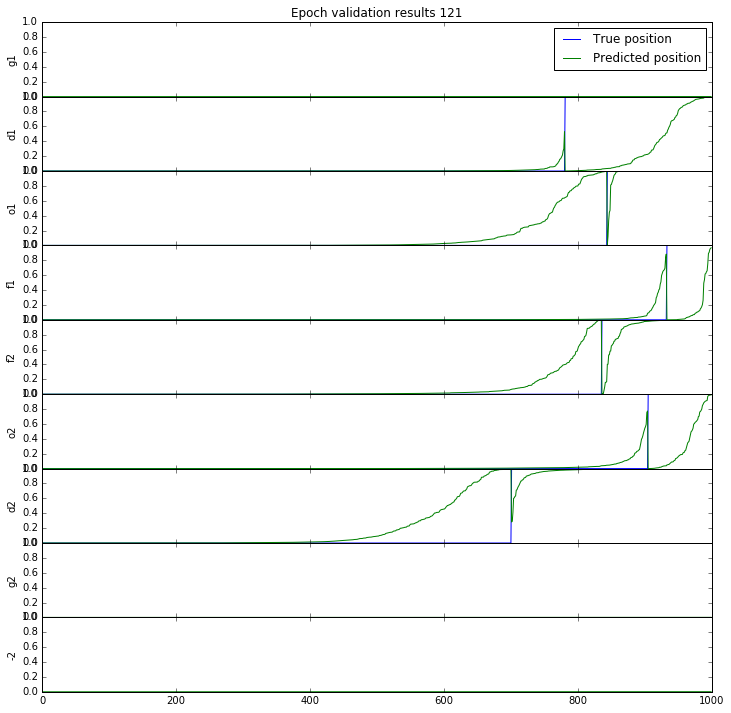

Wrote model to .\Models\weights_121.hdf
Epoch 122/122
176/175 [==============================] - 63s - loss: 0.2248 - categorical_accuracy: 0.9330 - val_loss: 0.8535 - val_categorical_accuracy: 0.7216
Wrote model to .\Models\weights_122.hdf
Epoch 123/123
176/175 [==============================] - 63s - loss: 0.2161 - categorical_accuracy: 0.9352 - val_loss: 1.1164 - val_categorical_accuracy: 0.6863
Wrote model to .\Models\weights_123.hdf
Epoch 124/124
176/175 [==============================] - 63s - loss: 0.2132 - categorical_accuracy: 0.9386 - val_loss: 0.7123 - val_categorical_accuracy: 0.7634
Wrote model to .\Models\weights_124.hdf
Epoch 125/125
176/175 [==============================] - 63s - loss: 0.2046 - categorical_accuracy: 0.9420 - val_loss: 0.6041 - val_categorical_accuracy: 0.8013
Wrote model to .\Models\weights_125.hdf
Epoch 126/126
176/175 [==============================] - 63s - loss: 0.2399 - categorical_accuracy: 0.9261 - val_loss: 0.8109 - val_categorical_accuracy: 0.

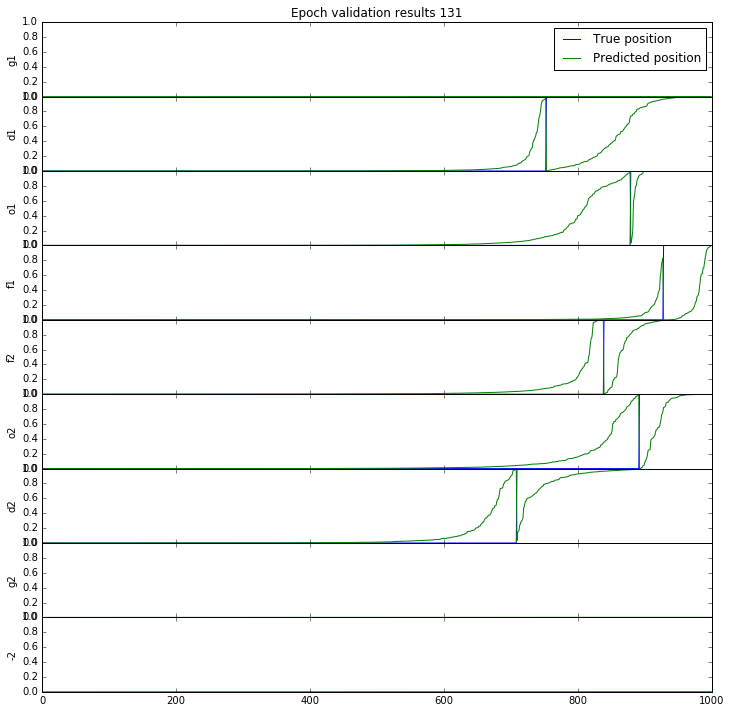

Wrote model to .\Models\weights_131.hdf
Epoch 132/132
176/175 [==============================] - 63s - loss: 0.1969 - categorical_accuracy: 0.9364 - val_loss: 0.8733 - val_categorical_accuracy: 0.7582
Wrote model to .\Models\weights_132.hdf
Epoch 133/133
176/175 [==============================] - 63s - loss: 0.1939 - categorical_accuracy: 0.9386 - val_loss: 0.7300 - val_categorical_accuracy: 0.7712
Wrote model to .\Models\weights_133.hdf
Epoch 134/134
176/175 [==============================] - 63s - loss: 0.2424 - categorical_accuracy: 0.9295 - val_loss: 1.1238 - val_categorical_accuracy: 0.6654
Wrote model to .\Models\weights_134.hdf
Epoch 135/135
176/175 [==============================] - 63s - loss: 0.2392 - categorical_accuracy: 0.9295 - val_loss: 0.7765 - val_categorical_accuracy: 0.7373
Wrote model to .\Models\weights_135.hdf
Epoch 136/136
176/175 [==============================] - 63s - loss: 0.2228 - categorical_accuracy: 0.9330 - val_loss: 0.7290 - val_categorical_accuracy: 0.

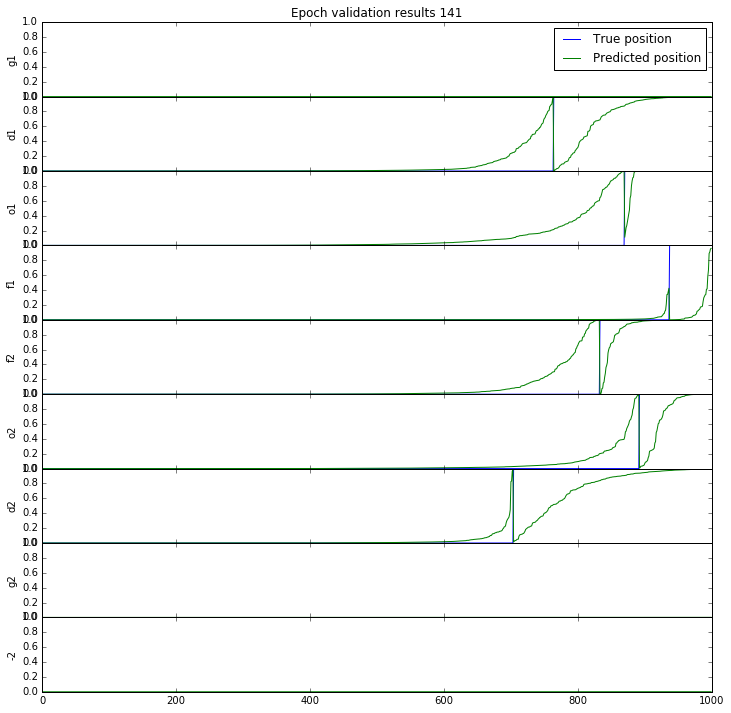

Wrote model to .\Models\weights_141.hdf
Epoch 142/142
176/175 [==============================] - 63s - loss: 0.1914 - categorical_accuracy: 0.9432 - val_loss: 0.6902 - val_categorical_accuracy: 0.7830
Wrote model to .\Models\weights_142.hdf
Epoch 143/143
176/175 [==============================] - 63s - loss: 0.1988 - categorical_accuracy: 0.9489 - val_loss: 1.0607 - val_categorical_accuracy: 0.7307
Wrote model to .\Models\weights_143.hdf
Epoch 144/144
176/175 [==============================] - 63s - loss: 0.1489 - categorical_accuracy: 0.9466 - val_loss: 0.8241 - val_categorical_accuracy: 0.7608
Wrote model to .\Models\weights_144.hdf
Epoch 145/145
176/175 [==============================] - 63s - loss: 0.1771 - categorical_accuracy: 0.9477 - val_loss: 1.0097 - val_categorical_accuracy: 0.7438
Wrote model to .\Models\weights_145.hdf
Epoch 146/146
176/175 [==============================] - 63s - loss: 0.2272 - categorical_accuracy: 0.9330 - val_loss: 0.9297 - val_categorical_accuracy: 0.

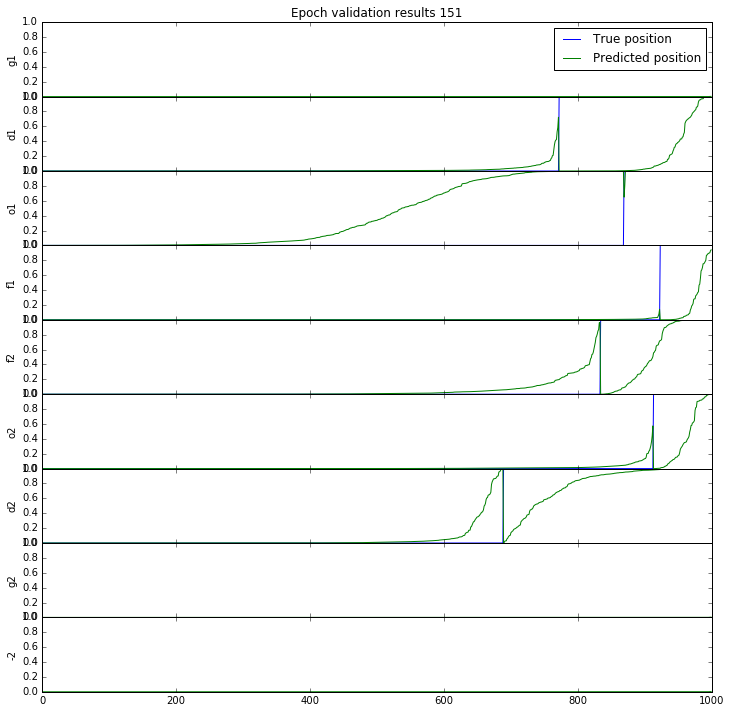

Wrote model to .\Models\weights_151.hdf
Epoch 152/152
176/175 [==============================] - 63s - loss: 0.1531 - categorical_accuracy: 0.9511 - val_loss: 1.3233 - val_categorical_accuracy: 0.6288
Wrote model to .\Models\weights_152.hdf
Epoch 153/153
176/175 [==============================] - 63s - loss: 0.2171 - categorical_accuracy: 0.9261 - val_loss: 0.6781 - val_categorical_accuracy: 0.8092
Wrote model to .\Models\weights_153.hdf
Epoch 154/154
176/175 [==============================] - 64s - loss: 0.1263 - categorical_accuracy: 0.9614 - val_loss: 1.1534 - val_categorical_accuracy: 0.6601
Wrote model to .\Models\weights_154.hdf
Epoch 155/155
176/175 [==============================] - 63s - loss: 0.1754 - categorical_accuracy: 0.9534 - val_loss: 1.1285 - val_categorical_accuracy: 0.6536
Wrote model to .\Models\weights_155.hdf
Epoch 156/156
176/175 [==============================] - 63s - loss: 0.1331 - categorical_accuracy: 0.9568 - val_loss: 0.9120 - val_categorical_accuracy: 0.

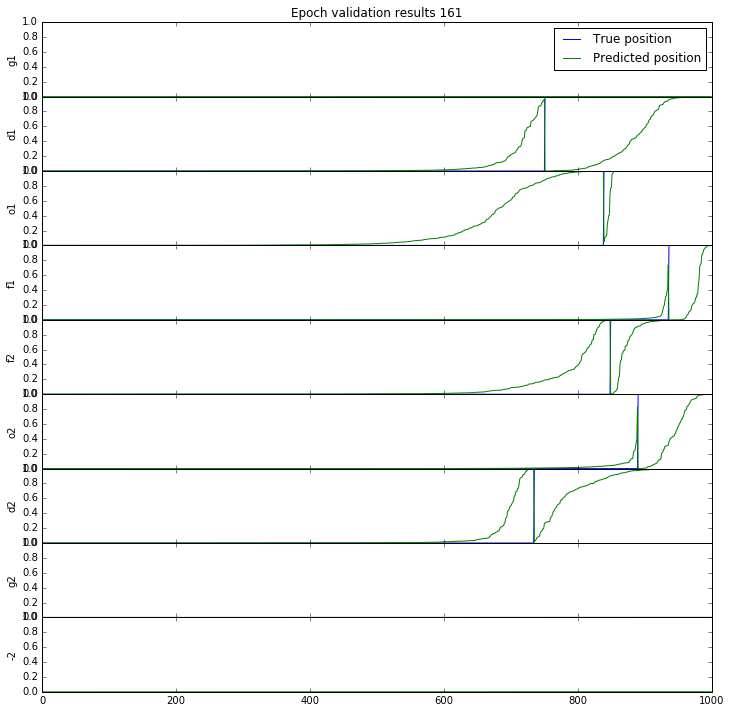

Wrote model to .\Models\weights_161.hdf
Epoch 162/162
176/175 [==============================] - 63s - loss: 0.1747 - categorical_accuracy: 0.9466 - val_loss: 1.0151 - val_categorical_accuracy: 0.7294
Wrote model to .\Models\weights_162.hdf
Epoch 163/163
176/175 [==============================] - 63s - loss: 0.1868 - categorical_accuracy: 0.9534 - val_loss: 1.4869 - val_categorical_accuracy: 0.6497
Wrote model to .\Models\weights_163.hdf
Epoch 164/164
176/175 [==============================] - 63s - loss: 0.2062 - categorical_accuracy: 0.9398 - val_loss: 0.9180 - val_categorical_accuracy: 0.7268
Wrote model to .\Models\weights_164.hdf
Epoch 165/165
176/175 [==============================] - 63s - loss: 0.1926 - categorical_accuracy: 0.9364 - val_loss: 0.9574 - val_categorical_accuracy: 0.7229
Wrote model to .\Models\weights_165.hdf
Epoch 166/166
176/175 [==============================] - 63s - loss: 0.1810 - categorical_accuracy: 0.9455 - val_loss: 0.8911 - val_categorical_accuracy: 0.

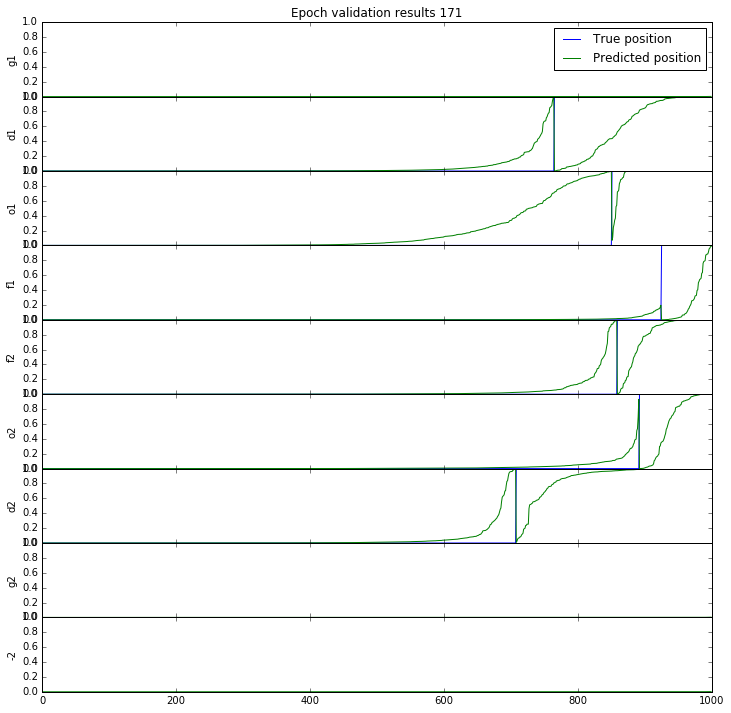

Wrote model to .\Models\weights_171.hdf
Epoch 172/172
176/175 [==============================] - 63s - loss: 0.1763 - categorical_accuracy: 0.9466 - val_loss: 0.8670 - val_categorical_accuracy: 0.7516
Wrote model to .\Models\weights_172.hdf
Epoch 173/173
176/175 [==============================] - 63s - loss: 0.1846 - categorical_accuracy: 0.9420 - val_loss: 0.7705 - val_categorical_accuracy: 0.7503
Wrote model to .\Models\weights_173.hdf
Epoch 174/174
176/175 [==============================] - 63s - loss: 0.1583 - categorical_accuracy: 0.9477 - val_loss: 0.8920 - val_categorical_accuracy: 0.7451
Wrote model to .\Models\weights_174.hdf
Epoch 175/175
176/175 [==============================] - 63s - loss: 0.1527 - categorical_accuracy: 0.9557 - val_loss: 1.2949 - val_categorical_accuracy: 0.6654
Wrote model to .\Models\weights_175.hdf
Epoch 176/176
176/175 [==============================] - 63s - loss: 0.1944 - categorical_accuracy: 0.9432 - val_loss: 1.1105 - val_categorical_accuracy: 0.

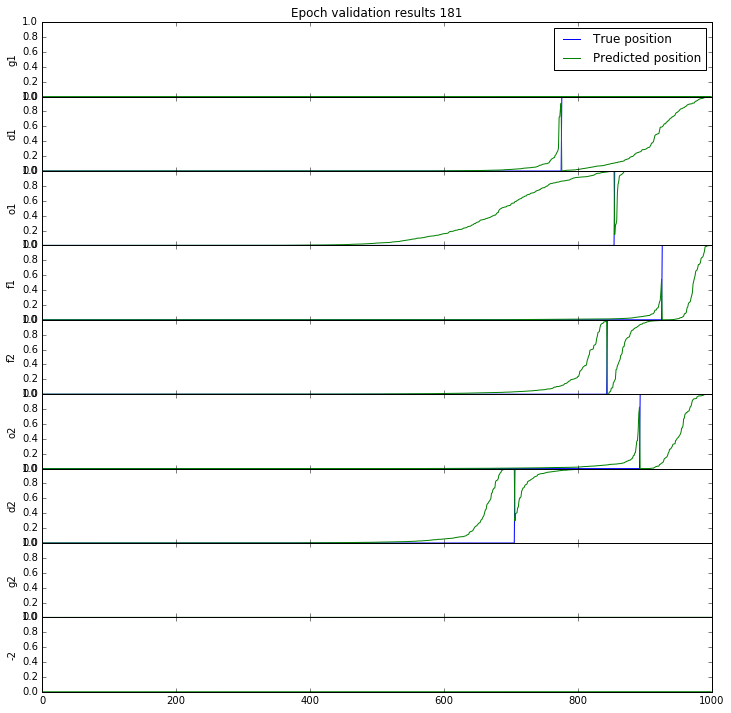

Wrote model to .\Models\weights_181.hdf
Epoch 182/182
176/175 [==============================] - 63s - loss: 0.1497 - categorical_accuracy: 0.9557 - val_loss: 0.8413 - val_categorical_accuracy: 0.7739
Wrote model to .\Models\weights_182.hdf
Epoch 183/183
176/175 [==============================] - 63s - loss: 0.1765 - categorical_accuracy: 0.9455 - val_loss: 1.1967 - val_categorical_accuracy: 0.6993
Wrote model to .\Models\weights_183.hdf
Epoch 184/184
176/175 [==============================] - 63s - loss: 0.1405 - categorical_accuracy: 0.9557 - val_loss: 1.3935 - val_categorical_accuracy: 0.6588
Wrote model to .\Models\weights_184.hdf
Epoch 185/185
176/175 [==============================] - 63s - loss: 0.1615 - categorical_accuracy: 0.9500 - val_loss: 0.6406 - val_categorical_accuracy: 0.8026
Wrote model to .\Models\weights_185.hdf
Epoch 186/186
176/175 [==============================] - 63s - loss: 0.1851 - categorical_accuracy: 0.9523 - val_loss: 0.9508 - val_categorical_accuracy: 0.

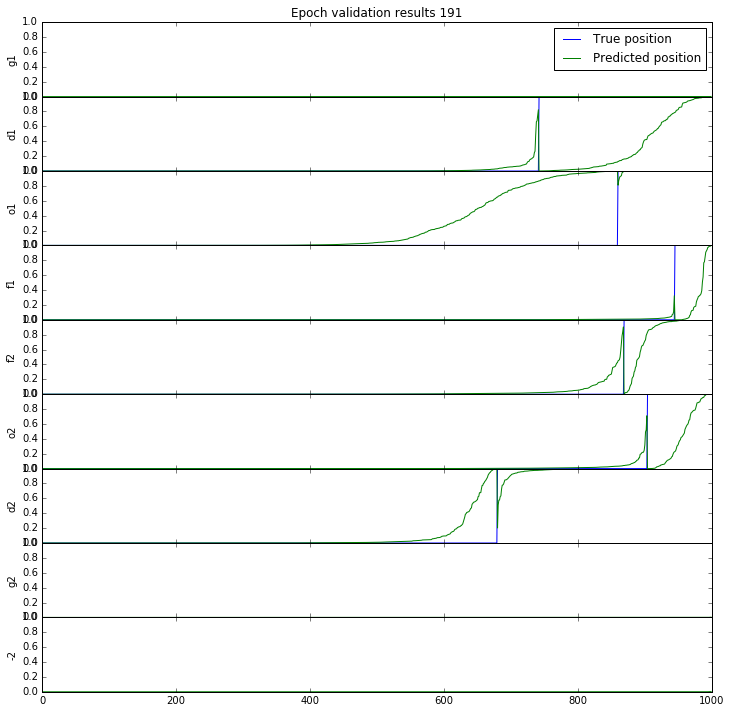

Wrote model to .\Models\weights_191.hdf
Epoch 192/192
176/175 [==============================] - 63s - loss: 0.1587 - categorical_accuracy: 0.9511 - val_loss: 0.9864 - val_categorical_accuracy: 0.7229
Wrote model to .\Models\weights_192.hdf
Epoch 193/193
176/175 [==============================] - 63s - loss: 0.1350 - categorical_accuracy: 0.9614 - val_loss: 0.7078 - val_categorical_accuracy: 0.7699
Wrote model to .\Models\weights_193.hdf
Epoch 194/194
176/175 [==============================] - 63s - loss: 0.1225 - categorical_accuracy: 0.9727 - val_loss: 0.8096 - val_categorical_accuracy: 0.7765
Wrote model to .\Models\weights_194.hdf
Epoch 195/195
176/175 [==============================] - 63s - loss: 0.1229 - categorical_accuracy: 0.9648 - val_loss: 1.4201 - val_categorical_accuracy: 0.6941
Wrote model to .\Models\weights_195.hdf
Epoch 196/196
176/175 [==============================] - 63s - loss: 0.1590 - categorical_accuracy: 0.9636 - val_loss: 2.3719 - val_categorical_accuracy: 0.

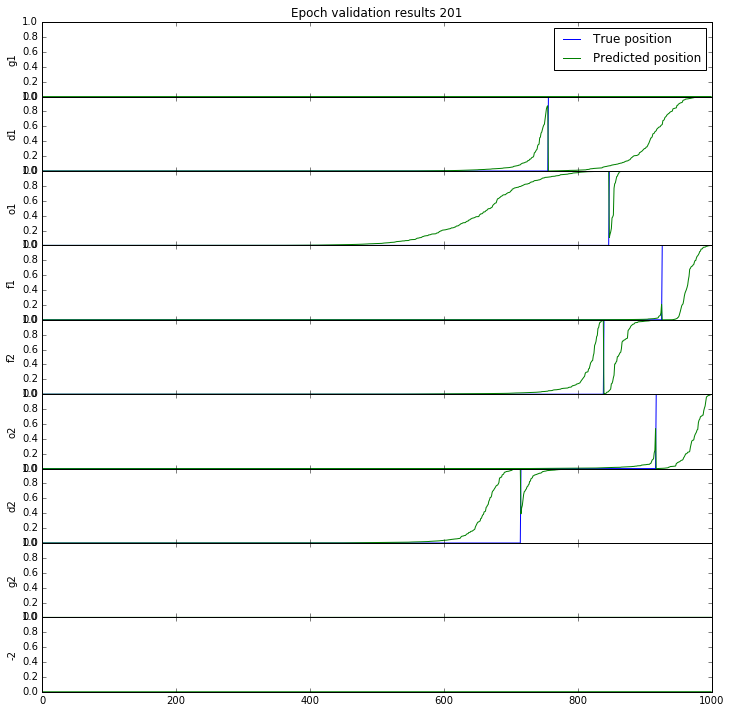

Wrote model to .\Models\weights_201.hdf
Epoch 202/202
176/175 [==============================] - 63s - loss: 0.1362 - categorical_accuracy: 0.9500 - val_loss: 0.7427 - val_categorical_accuracy: 0.7791
Wrote model to .\Models\weights_202.hdf
Epoch 203/203
176/175 [==============================] - 63s - loss: 0.1150 - categorical_accuracy: 0.9659 - val_loss: 1.3144 - val_categorical_accuracy: 0.7150
Wrote model to .\Models\weights_203.hdf
Epoch 204/204
176/175 [==============================] - 64s - loss: 0.1621 - categorical_accuracy: 0.9568 - val_loss: 1.1162 - val_categorical_accuracy: 0.7490
Wrote model to .\Models\weights_204.hdf
Epoch 205/205
176/175 [==============================] - 63s - loss: 0.1219 - categorical_accuracy: 0.9602 - val_loss: 0.6853 - val_categorical_accuracy: 0.8065
Wrote model to .\Models\weights_205.hdf
Epoch 206/206
176/175 [==============================] - 63s - loss: 0.1511 - categorical_accuracy: 0.9614 - val_loss: 0.8779 - val_categorical_accuracy: 0.

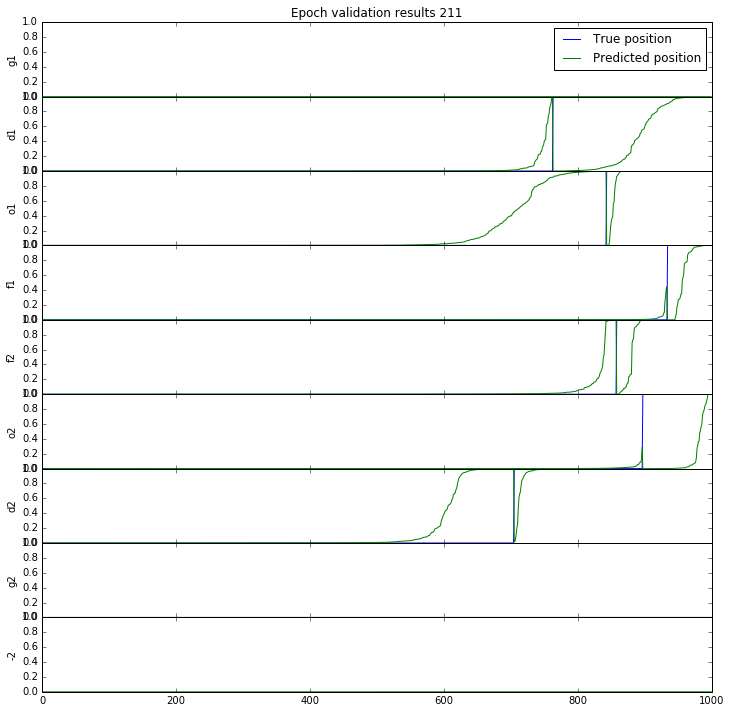

Wrote model to .\Models\weights_211.hdf
Epoch 212/212
176/175 [==============================] - 63s - loss: 0.1255 - categorical_accuracy: 0.9648 - val_loss: 1.2007 - val_categorical_accuracy: 0.7647
Wrote model to .\Models\weights_212.hdf
Epoch 213/213
176/175 [==============================] - 63s - loss: 0.1539 - categorical_accuracy: 0.9534 - val_loss: 0.9733 - val_categorical_accuracy: 0.7621
Wrote model to .\Models\weights_213.hdf
Epoch 214/214
176/175 [==============================] - 63s - loss: 0.1248 - categorical_accuracy: 0.9659 - val_loss: 1.7872 - val_categorical_accuracy: 0.6706
Wrote model to .\Models\weights_214.hdf
Epoch 215/215
176/175 [==============================] - 63s - loss: 0.1694 - categorical_accuracy: 0.9500 - val_loss: 0.8339 - val_categorical_accuracy: 0.7425
Wrote model to .\Models\weights_215.hdf
Epoch 216/216
176/175 [==============================] - 63s - loss: 0.1072 - categorical_accuracy: 0.9670 - val_loss: 0.8459 - val_categorical_accuracy: 0.

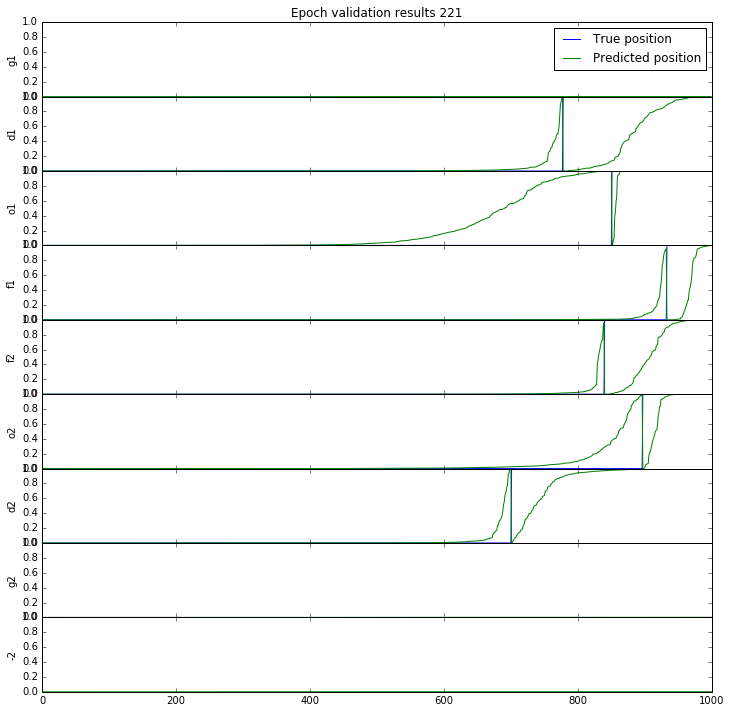

Wrote model to .\Models\weights_221.hdf
Epoch 222/222
176/175 [==============================] - 63s - loss: 0.1456 - categorical_accuracy: 0.9568 - val_loss: 0.8790 - val_categorical_accuracy: 0.7477
Wrote model to .\Models\weights_222.hdf
Epoch 223/223
176/175 [==============================] - 63s - loss: 0.1452 - categorical_accuracy: 0.9602 - val_loss: 0.9471 - val_categorical_accuracy: 0.7660
Wrote model to .\Models\weights_223.hdf
Epoch 224/224
176/175 [==============================] - 63s - loss: 0.1197 - categorical_accuracy: 0.9511 - val_loss: 0.8577 - val_categorical_accuracy: 0.7804
Wrote model to .\Models\weights_224.hdf
Epoch 225/225
176/175 [==============================] - 63s - loss: 0.1438 - categorical_accuracy: 0.9591 - val_loss: 1.0116 - val_categorical_accuracy: 0.7294
Wrote model to .\Models\weights_225.hdf
Epoch 226/226
176/175 [==============================] - 63s - loss: 0.1376 - categorical_accuracy: 0.9568 - val_loss: 1.3143 - val_categorical_accuracy: 0.

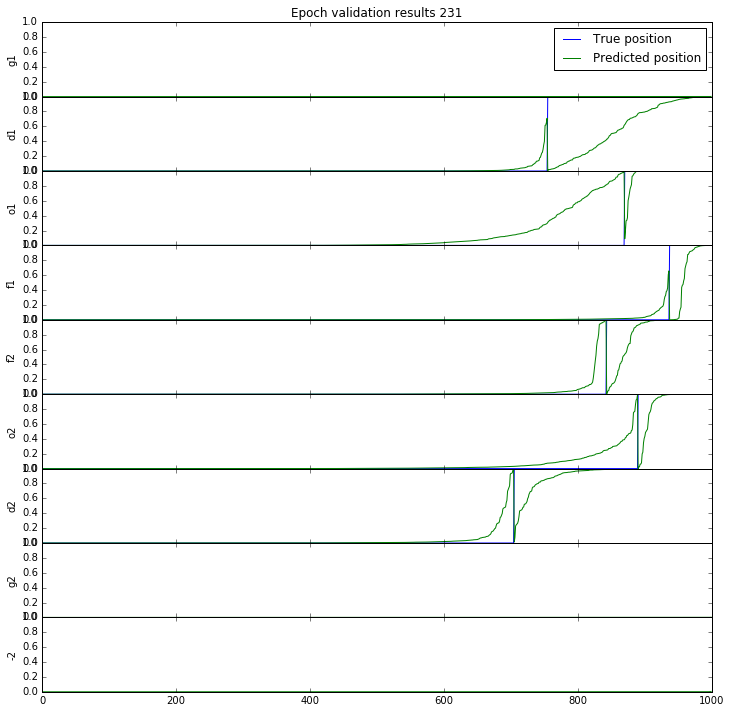

Wrote model to .\Models\weights_231.hdf
Epoch 232/232
176/175 [==============================] - 63s - loss: 0.1371 - categorical_accuracy: 0.9614 - val_loss: 0.5858 - val_categorical_accuracy: 0.8471
Wrote model to .\Models\weights_232.hdf
Epoch 233/233
176/175 [==============================] - 63s - loss: 0.1340 - categorical_accuracy: 0.9625 - val_loss: 0.8447 - val_categorical_accuracy: 0.7739
Wrote model to .\Models\weights_233.hdf
Epoch 234/234
176/175 [==============================] - 63s - loss: 0.1319 - categorical_accuracy: 0.9670 - val_loss: 0.6113 - val_categorical_accuracy: 0.8405
Wrote model to .\Models\weights_234.hdf
Epoch 235/235
176/175 [==============================] - 63s - loss: 0.1343 - categorical_accuracy: 0.9636 - val_loss: 0.5781 - val_categorical_accuracy: 0.8458
Wrote model to .\Models\weights_235.hdf
Epoch 236/236
176/175 [==============================] - 63s - loss: 0.1309 - categorical_accuracy: 0.9545 - val_loss: 0.5546 - val_categorical_accuracy: 0.

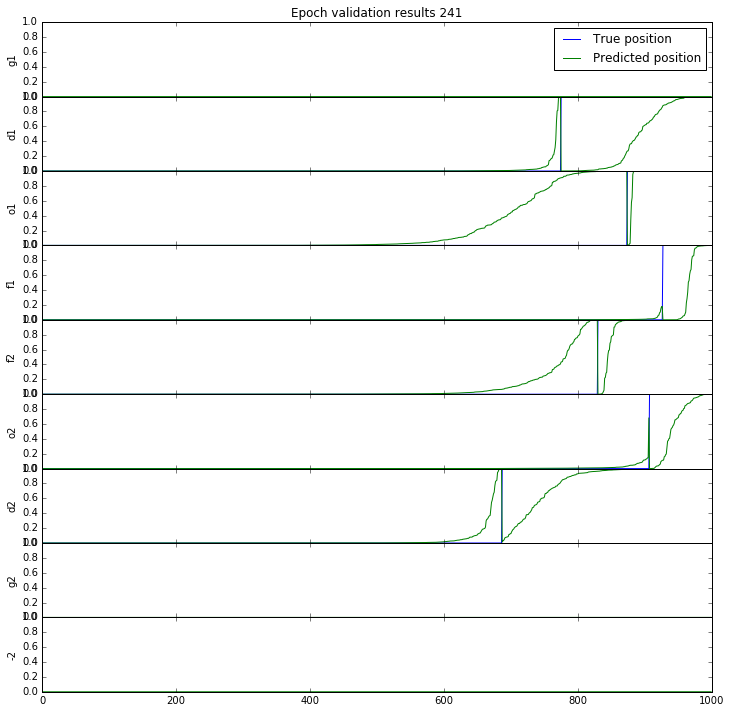

Wrote model to .\Models\weights_241.hdf
Epoch 242/242
176/175 [==============================] - 63s - loss: 0.1367 - categorical_accuracy: 0.9591 - val_loss: 0.6760 - val_categorical_accuracy: 0.8288
Wrote model to .\Models\weights_242.hdf
Epoch 243/243
176/175 [==============================] - 63s - loss: 0.1289 - categorical_accuracy: 0.9636 - val_loss: 0.6587 - val_categorical_accuracy: 0.8353
Wrote model to .\Models\weights_243.hdf
Epoch 244/244
176/175 [==============================] - 63s - loss: 0.1141 - categorical_accuracy: 0.9693 - val_loss: 1.1714 - val_categorical_accuracy: 0.7647
Wrote model to .\Models\weights_244.hdf
Epoch 245/245
176/175 [==============================] - 63s - loss: 0.1205 - categorical_accuracy: 0.9614 - val_loss: 1.3610 - val_categorical_accuracy: 0.7203
Wrote model to .\Models\weights_245.hdf
Epoch 246/246
176/175 [==============================] - 63s - loss: 0.1359 - categorical_accuracy: 0.9511 - val_loss: 0.7875 - val_categorical_accuracy: 0.

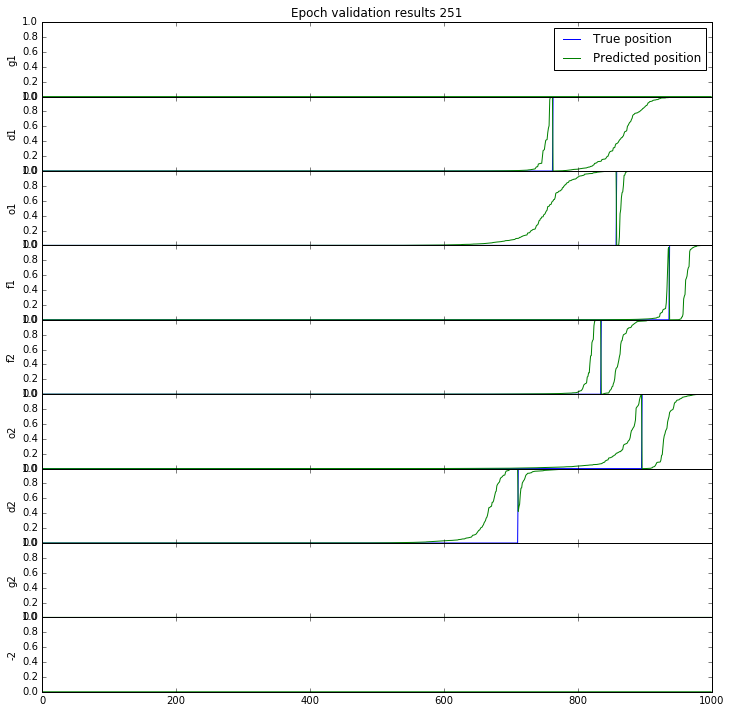

Wrote model to .\Models\weights_251.hdf
Epoch 252/252
176/175 [==============================] - 63s - loss: 0.1573 - categorical_accuracy: 0.9636 - val_loss: 0.7296 - val_categorical_accuracy: 0.7830
Wrote model to .\Models\weights_252.hdf
Epoch 253/253
176/175 [==============================] - 63s - loss: 0.0869 - categorical_accuracy: 0.9739 - val_loss: 1.0077 - val_categorical_accuracy: 0.7582
Wrote model to .\Models\weights_253.hdf
Epoch 254/254
176/175 [==============================] - 63s - loss: 0.1290 - categorical_accuracy: 0.9659 - val_loss: 0.6070 - val_categorical_accuracy: 0.8170
Wrote model to .\Models\weights_254.hdf
Epoch 255/255
176/175 [==============================] - 63s - loss: 0.1255 - categorical_accuracy: 0.9659 - val_loss: 1.0328 - val_categorical_accuracy: 0.7399
Wrote model to .\Models\weights_255.hdf
Epoch 256/256
176/175 [==============================] - 63s - loss: 0.1623 - categorical_accuracy: 0.9580 - val_loss: 0.4550 - val_categorical_accuracy: 0.

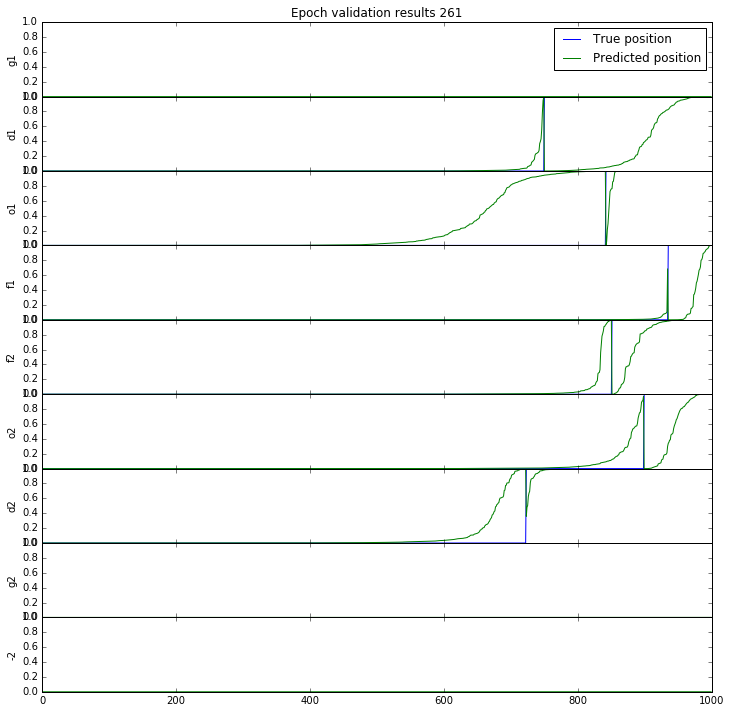

Wrote model to .\Models\weights_261.hdf
Epoch 262/262
176/175 [==============================] - 63s - loss: 0.1340 - categorical_accuracy: 0.9580 - val_loss: 0.7638 - val_categorical_accuracy: 0.8039
Wrote model to .\Models\weights_262.hdf
Epoch 263/263
176/175 [==============================] - 63s - loss: 0.1420 - categorical_accuracy: 0.9523 - val_loss: 0.9500 - val_categorical_accuracy: 0.7556
Wrote model to .\Models\weights_263.hdf
Epoch 264/264
176/175 [==============================] - 63s - loss: 0.1362 - categorical_accuracy: 0.9625 - val_loss: 1.0954 - val_categorical_accuracy: 0.7425
Wrote model to .\Models\weights_264.hdf
Epoch 265/265
176/175 [==============================] - 63s - loss: 0.1222 - categorical_accuracy: 0.9682 - val_loss: 0.9842 - val_categorical_accuracy: 0.7673
Wrote model to .\Models\weights_265.hdf
Epoch 266/266
176/175 [==============================] - 63s - loss: 0.1004 - categorical_accuracy: 0.9739 - val_loss: 1.3517 - val_categorical_accuracy: 0.

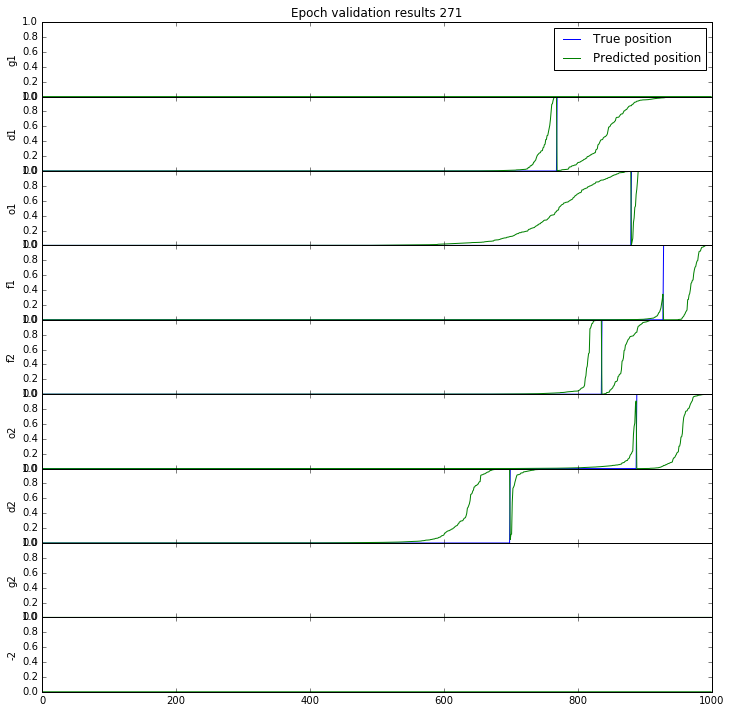

Wrote model to .\Models\weights_271.hdf
Epoch 272/272
176/175 [==============================] - 63s - loss: 0.1218 - categorical_accuracy: 0.9705 - val_loss: 1.1444 - val_categorical_accuracy: 0.7242
Wrote model to .\Models\weights_272.hdf
Epoch 273/273
176/175 [==============================] - 63s - loss: 0.1056 - categorical_accuracy: 0.9670 - val_loss: 1.2375 - val_categorical_accuracy: 0.6824
Wrote model to .\Models\weights_273.hdf
Epoch 274/274
176/175 [==============================] - 63s - loss: 0.1117 - categorical_accuracy: 0.9693 - val_loss: 0.8440 - val_categorical_accuracy: 0.7804
Wrote model to .\Models\weights_274.hdf
Epoch 275/275
176/175 [==============================] - 63s - loss: 0.1204 - categorical_accuracy: 0.9648 - val_loss: 1.3054 - val_categorical_accuracy: 0.6889
Wrote model to .\Models\weights_275.hdf
Epoch 276/276
176/175 [==============================] - 63s - loss: 0.0904 - categorical_accuracy: 0.9739 - val_loss: 0.8800 - val_categorical_accuracy: 0.

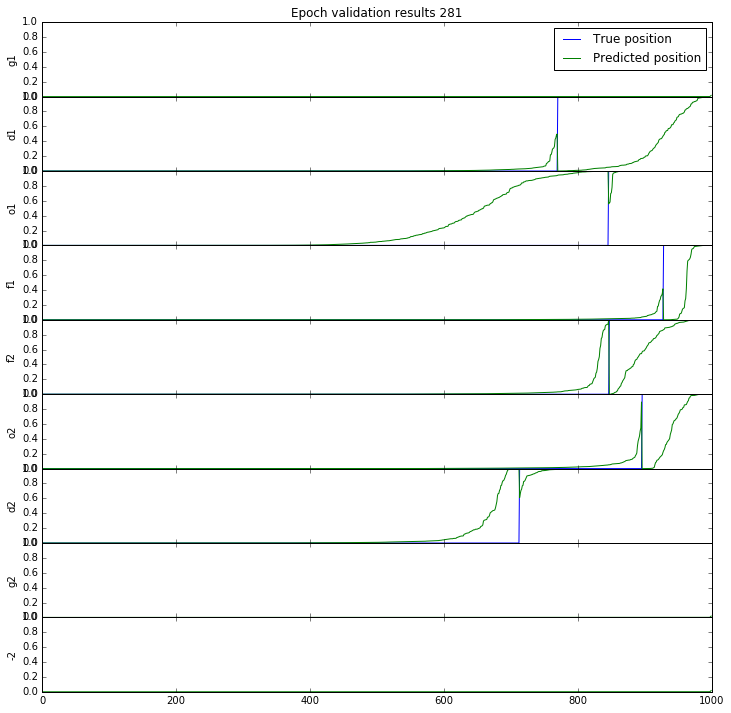

Wrote model to .\Models\weights_281.hdf
Epoch 282/282
176/175 [==============================] - 63s - loss: 0.1017 - categorical_accuracy: 0.9761 - val_loss: 1.0134 - val_categorical_accuracy: 0.7111
Wrote model to .\Models\weights_282.hdf
Epoch 283/283
176/175 [==============================] - 63s - loss: 0.1388 - categorical_accuracy: 0.9591 - val_loss: 0.8692 - val_categorical_accuracy: 0.7386
Wrote model to .\Models\weights_283.hdf
Epoch 284/284
176/175 [==============================] - 63s - loss: 0.0899 - categorical_accuracy: 0.9739 - val_loss: 1.1070 - val_categorical_accuracy: 0.7098
Wrote model to .\Models\weights_284.hdf
Epoch 285/285
176/175 [==============================] - 63s - loss: 0.1541 - categorical_accuracy: 0.9636 - val_loss: 0.7807 - val_categorical_accuracy: 0.7556
Wrote model to .\Models\weights_285.hdf
Epoch 286/286
176/175 [==============================] - 63s - loss: 0.1444 - categorical_accuracy: 0.9636 - val_loss: 1.0189 - val_categorical_accuracy: 0.

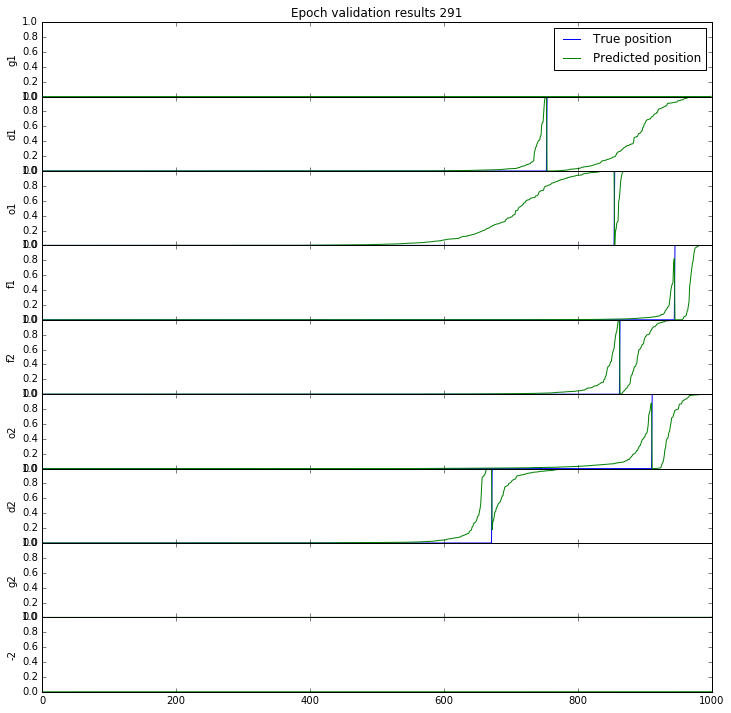

Wrote model to .\Models\weights_291.hdf
Epoch 292/292
176/175 [==============================] - 63s - loss: 0.1141 - categorical_accuracy: 0.9705 - val_loss: 1.0618 - val_categorical_accuracy: 0.7503
Wrote model to .\Models\weights_292.hdf
Epoch 293/293
176/175 [==============================] - 63s - loss: 0.0879 - categorical_accuracy: 0.9716 - val_loss: 0.9909 - val_categorical_accuracy: 0.7268
Wrote model to .\Models\weights_293.hdf
Epoch 294/294
176/175 [==============================] - 63s - loss: 0.1132 - categorical_accuracy: 0.9648 - val_loss: 1.9167 - val_categorical_accuracy: 0.6837
Wrote model to .\Models\weights_294.hdf
Epoch 295/295
176/175 [==============================] - 63s - loss: 0.1212 - categorical_accuracy: 0.9705 - val_loss: 1.2525 - val_categorical_accuracy: 0.7281
Wrote model to .\Models\weights_295.hdf
Epoch 296/296
176/175 [==============================] - 63s - loss: 0.0728 - categorical_accuracy: 0.9795 - val_loss: 1.1238 - val_categorical_accuracy: 0.

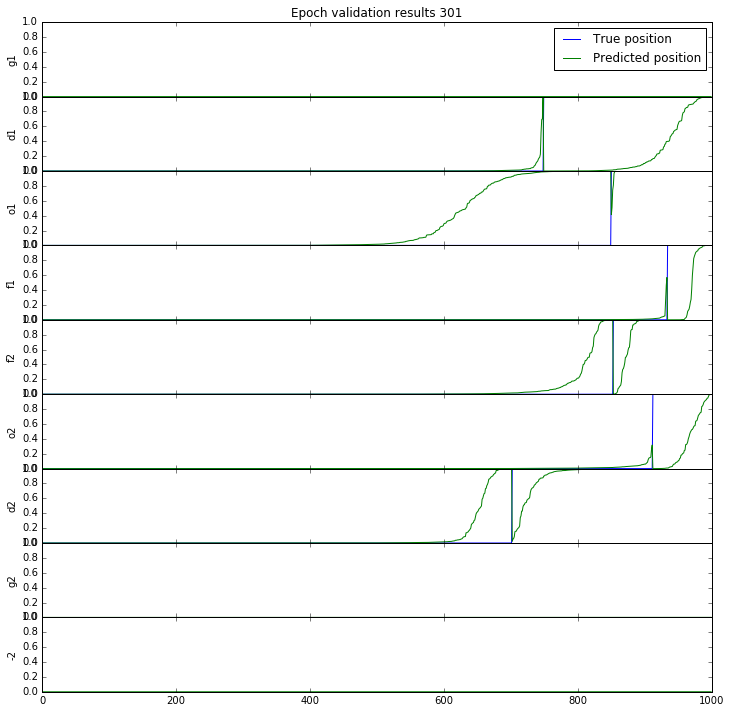

Wrote model to .\Models\weights_301.hdf
Epoch 302/302
176/175 [==============================] - 63s - loss: 0.0764 - categorical_accuracy: 0.9750 - val_loss: 0.7658 - val_categorical_accuracy: 0.7752
Wrote model to .\Models\weights_302.hdf
Epoch 303/303
176/175 [==============================] - 63s - loss: 0.0776 - categorical_accuracy: 0.9795 - val_loss: 1.0618 - val_categorical_accuracy: 0.7569
Wrote model to .\Models\weights_303.hdf
Epoch 304/304
176/175 [==============================] - 63s - loss: 0.1022 - categorical_accuracy: 0.9750 - val_loss: 0.7429 - val_categorical_accuracy: 0.8065
Wrote model to .\Models\weights_304.hdf
Epoch 305/305
176/175 [==============================] - 63s - loss: 0.1171 - categorical_accuracy: 0.9693 - val_loss: 0.6135 - val_categorical_accuracy: 0.8458
Wrote model to .\Models\weights_305.hdf
Epoch 306/306
176/175 [==============================] - 63s - loss: 0.1020 - categorical_accuracy: 0.9648 - val_loss: 0.9044 - val_categorical_accuracy: 0.

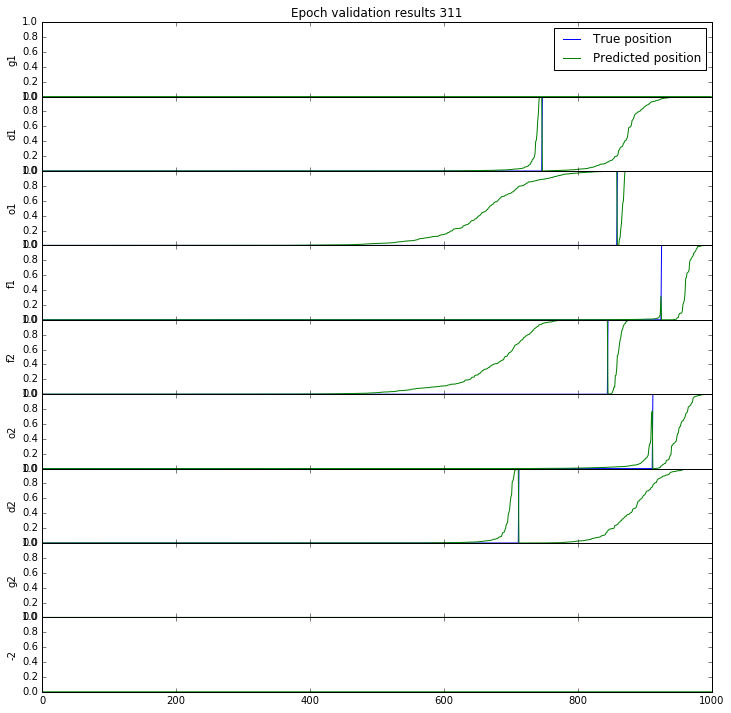

Wrote model to .\Models\weights_311.hdf
Epoch 312/312
176/175 [==============================] - 63s - loss: 0.0947 - categorical_accuracy: 0.9773 - val_loss: 1.6253 - val_categorical_accuracy: 0.6654
Wrote model to .\Models\weights_312.hdf
Epoch 313/313
176/175 [==============================] - 63s - loss: 0.0954 - categorical_accuracy: 0.9773 - val_loss: 0.9452 - val_categorical_accuracy: 0.7359
Wrote model to .\Models\weights_313.hdf
Epoch 314/314
176/175 [==============================] - 63s - loss: 0.0769 - categorical_accuracy: 0.9727 - val_loss: 1.0272 - val_categorical_accuracy: 0.6810
Wrote model to .\Models\weights_314.hdf
Epoch 315/315
176/175 [==============================] - 63s - loss: 0.1021 - categorical_accuracy: 0.9693 - val_loss: 1.3648 - val_categorical_accuracy: 0.7046
Wrote model to .\Models\weights_315.hdf
Epoch 316/316
176/175 [==============================] - 63s - loss: 0.0764 - categorical_accuracy: 0.9773 - val_loss: 1.0128 - val_categorical_accuracy: 0.

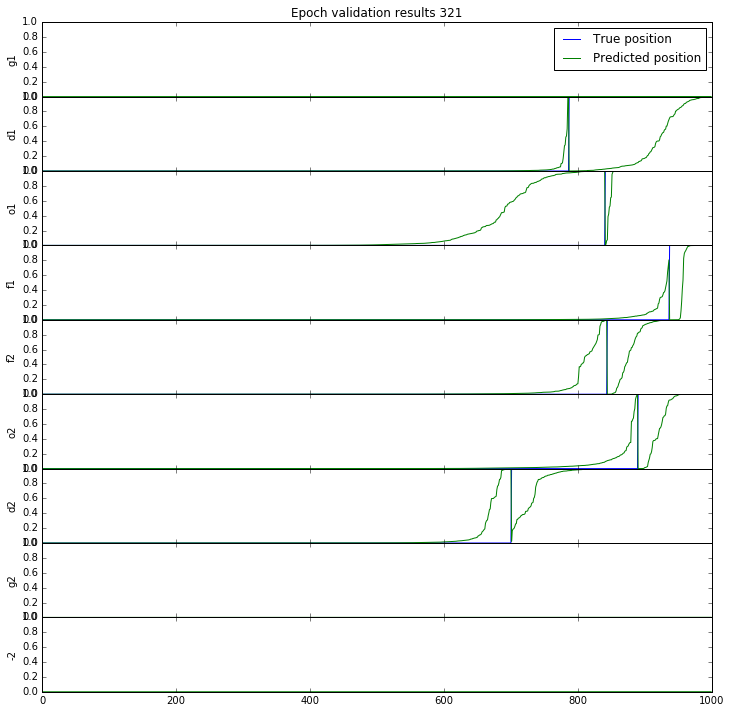

Wrote model to .\Models\weights_321.hdf
Epoch 322/322
176/175 [==============================] - 63s - loss: 0.1209 - categorical_accuracy: 0.9716 - val_loss: 1.2606 - val_categorical_accuracy: 0.7190
Wrote model to .\Models\weights_322.hdf
Epoch 323/323
176/175 [==============================] - 63s - loss: 0.0752 - categorical_accuracy: 0.9727 - val_loss: 0.8736 - val_categorical_accuracy: 0.7556
Wrote model to .\Models\weights_323.hdf
Epoch 324/324
176/175 [==============================] - 63s - loss: 0.1039 - categorical_accuracy: 0.9682 - val_loss: 1.2744 - val_categorical_accuracy: 0.6928
Wrote model to .\Models\weights_324.hdf
Epoch 325/325
176/175 [==============================] - 63s - loss: 0.0722 - categorical_accuracy: 0.9773 - val_loss: 0.9842 - val_categorical_accuracy: 0.7752
Wrote model to .\Models\weights_325.hdf
Epoch 326/326
176/175 [==============================] - 63s - loss: 0.1363 - categorical_accuracy: 0.9682 - val_loss: 1.2370 - val_categorical_accuracy: 0.

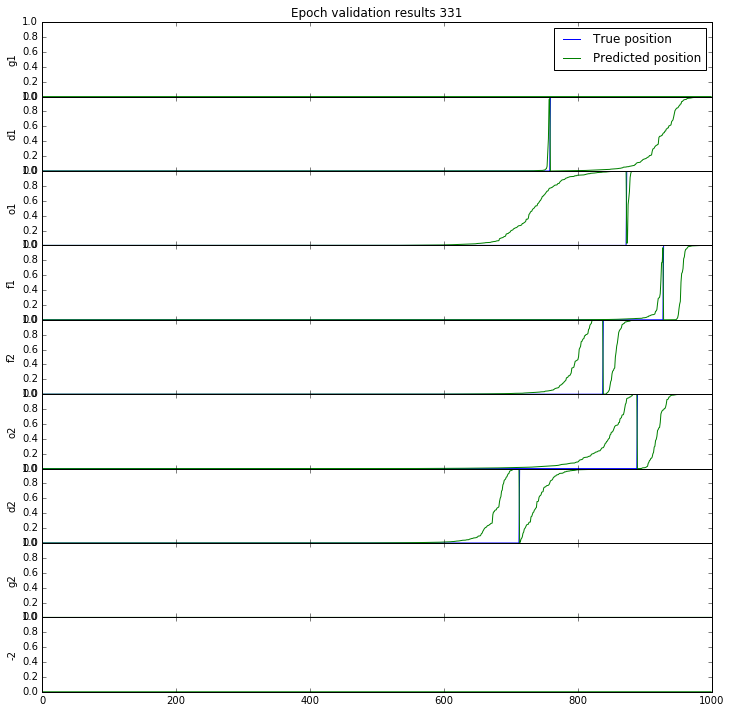

Wrote model to .\Models\weights_331.hdf
Epoch 332/332
176/175 [==============================] - 63s - loss: 0.0939 - categorical_accuracy: 0.9727 - val_loss: 1.2712 - val_categorical_accuracy: 0.7386
Wrote model to .\Models\weights_332.hdf
Epoch 333/333
176/175 [==============================] - 63s - loss: 0.0784 - categorical_accuracy: 0.9773 - val_loss: 0.8402 - val_categorical_accuracy: 0.8013
Wrote model to .\Models\weights_333.hdf
Epoch 334/334
176/175 [==============================] - 63s - loss: 0.0917 - categorical_accuracy: 0.9773 - val_loss: 1.1295 - val_categorical_accuracy: 0.7190
Wrote model to .\Models\weights_334.hdf
Epoch 335/335
176/175 [==============================] - 63s - loss: 0.1183 - categorical_accuracy: 0.9739 - val_loss: 0.6412 - val_categorical_accuracy: 0.8039
Wrote model to .\Models\weights_335.hdf
Epoch 336/336
176/175 [==============================] - 63s - loss: 0.0604 - categorical_accuracy: 0.9784 - val_loss: 0.8749 - val_categorical_accuracy: 0.

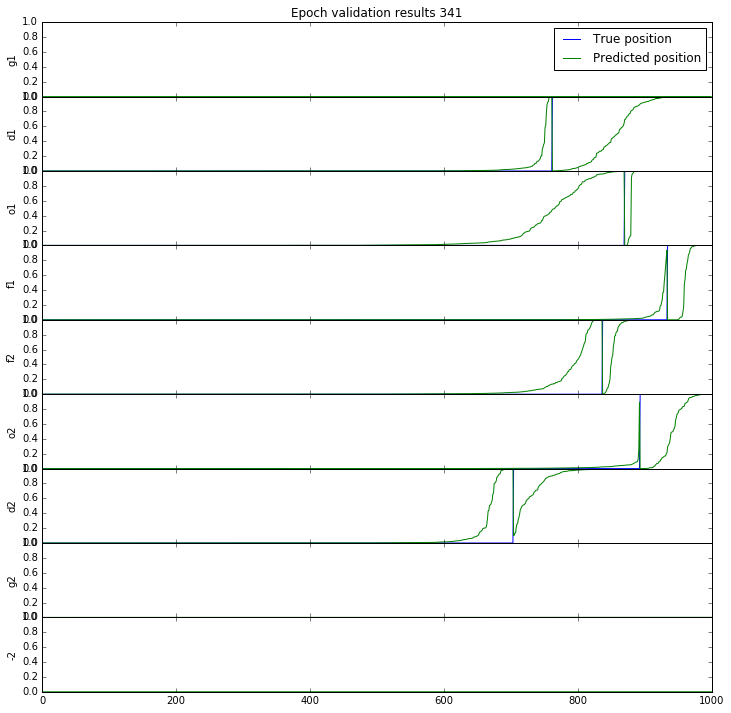

Wrote model to .\Models\weights_341.hdf
Epoch 342/342
176/175 [==============================] - 63s - loss: 0.1366 - categorical_accuracy: 0.9659 - val_loss: 0.9027 - val_categorical_accuracy: 0.7712
Wrote model to .\Models\weights_342.hdf
Epoch 343/343
176/175 [==============================] - 63s - loss: 0.1107 - categorical_accuracy: 0.9739 - val_loss: 0.8986 - val_categorical_accuracy: 0.7712
Wrote model to .\Models\weights_343.hdf
Epoch 344/344
176/175 [==============================] - 63s - loss: 0.0870 - categorical_accuracy: 0.9795 - val_loss: 1.3079 - val_categorical_accuracy: 0.7595
Wrote model to .\Models\weights_344.hdf
Epoch 345/345
176/175 [==============================] - 63s - loss: 0.0915 - categorical_accuracy: 0.9727 - val_loss: 0.8623 - val_categorical_accuracy: 0.7935
Wrote model to .\Models\weights_345.hdf
Epoch 346/346
176/175 [==============================] - 63s - loss: 0.0860 - categorical_accuracy: 0.9750 - val_loss: 0.5923 - val_categorical_accuracy: 0.

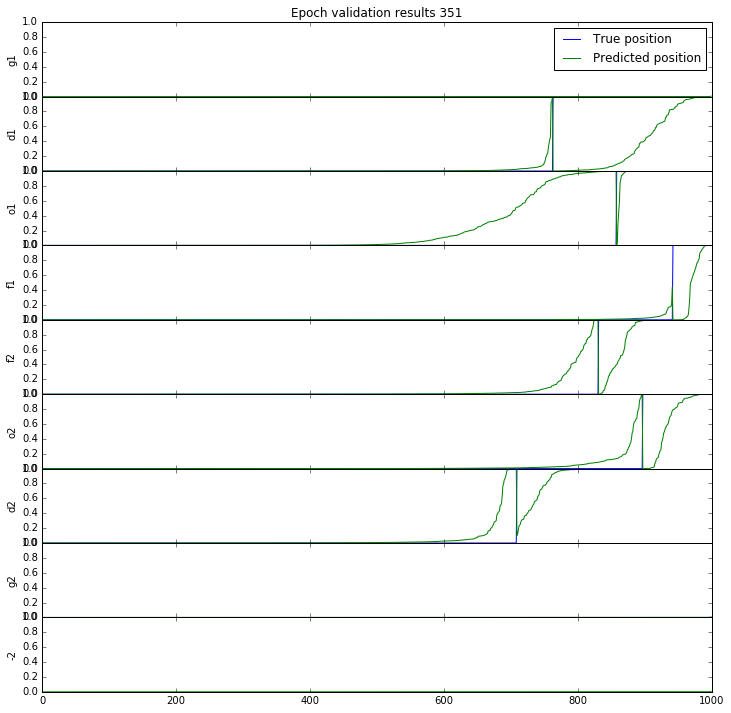

Wrote model to .\Models\weights_351.hdf
Epoch 352/352
176/175 [==============================] - 63s - loss: 0.1024 - categorical_accuracy: 0.9739 - val_loss: 1.0315 - val_categorical_accuracy: 0.7542
Wrote model to .\Models\weights_352.hdf
Epoch 353/353
176/175 [==============================] - 63s - loss: 0.0909 - categorical_accuracy: 0.9761 - val_loss: 1.2802 - val_categorical_accuracy: 0.7438
Wrote model to .\Models\weights_353.hdf
Epoch 354/354
176/175 [==============================] - 63s - loss: 0.1188 - categorical_accuracy: 0.9670 - val_loss: 1.4399 - val_categorical_accuracy: 0.7150
Wrote model to .\Models\weights_354.hdf
Epoch 355/355
176/175 [==============================] - 63s - loss: 0.0761 - categorical_accuracy: 0.9739 - val_loss: 0.6878 - val_categorical_accuracy: 0.8314
Wrote model to .\Models\weights_355.hdf
Epoch 356/356
176/175 [==============================] - 63s - loss: 0.0730 - categorical_accuracy: 0.9795 - val_loss: 0.6512 - val_categorical_accuracy: 0.

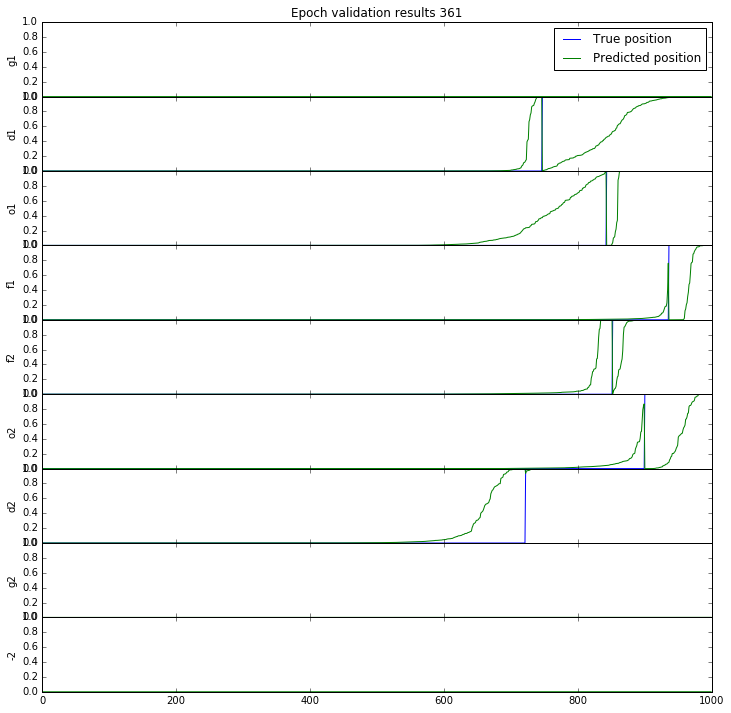

Wrote model to .\Models\weights_361.hdf
Epoch 362/362
176/175 [==============================] - 63s - loss: 0.0897 - categorical_accuracy: 0.9761 - val_loss: 1.1016 - val_categorical_accuracy: 0.7699
Wrote model to .\Models\weights_362.hdf
Epoch 363/363
176/175 [==============================] - 63s - loss: 0.0630 - categorical_accuracy: 0.9784 - val_loss: 0.6560 - val_categorical_accuracy: 0.8575
Wrote model to .\Models\weights_363.hdf
Epoch 364/364
176/175 [==============================] - 63s - loss: 0.0860 - categorical_accuracy: 0.9795 - val_loss: 0.5354 - val_categorical_accuracy: 0.8810
Wrote model to .\Models\weights_364.hdf
Epoch 365/365
176/175 [==============================] - 63s - loss: 0.0939 - categorical_accuracy: 0.9818 - val_loss: 1.3435 - val_categorical_accuracy: 0.7608
Wrote model to .\Models\weights_365.hdf
Epoch 366/366
176/175 [==============================] - 63s - loss: 0.1217 - categorical_accuracy: 0.9716 - val_loss: 1.1984 - val_categorical_accuracy: 0.

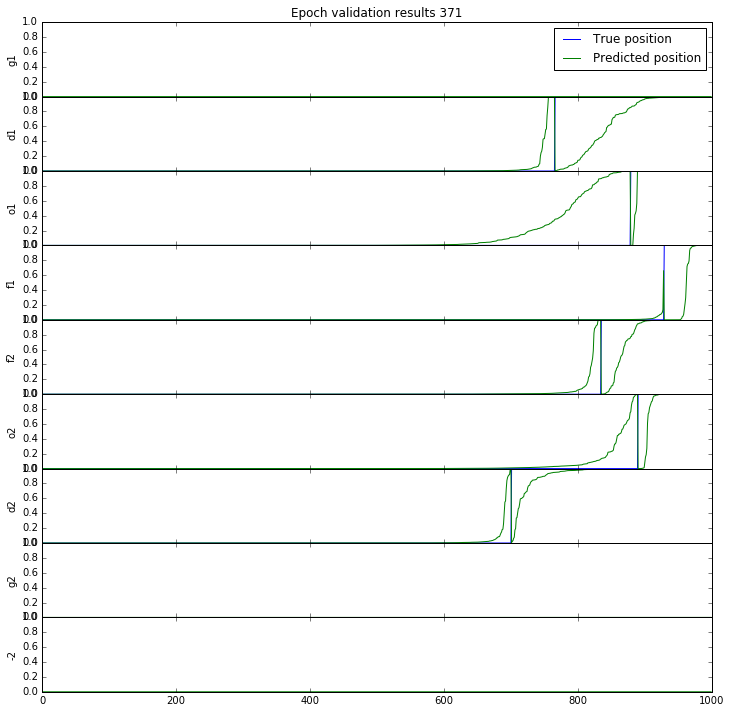

Wrote model to .\Models\weights_371.hdf
Epoch 372/372
176/175 [==============================] - 63s - loss: 0.1272 - categorical_accuracy: 0.9659 - val_loss: 0.8430 - val_categorical_accuracy: 0.8248
Wrote model to .\Models\weights_372.hdf
Epoch 373/373
176/175 [==============================] - 63s - loss: 0.1093 - categorical_accuracy: 0.9705 - val_loss: 0.7780 - val_categorical_accuracy: 0.8562
Wrote model to .\Models\weights_373.hdf
Epoch 374/374
176/175 [==============================] - 63s - loss: 0.0878 - categorical_accuracy: 0.9761 - val_loss: 1.0795 - val_categorical_accuracy: 0.7569
Wrote model to .\Models\weights_374.hdf
Epoch 375/375
176/175 [==============================] - 63s - loss: 0.1132 - categorical_accuracy: 0.9727 - val_loss: 0.8432 - val_categorical_accuracy: 0.8105
Wrote model to .\Models\weights_375.hdf
Epoch 376/376
176/175 [==============================] - 63s - loss: 0.0525 - categorical_accuracy: 0.9841 - val_loss: 1.3135 - val_categorical_accuracy: 0.

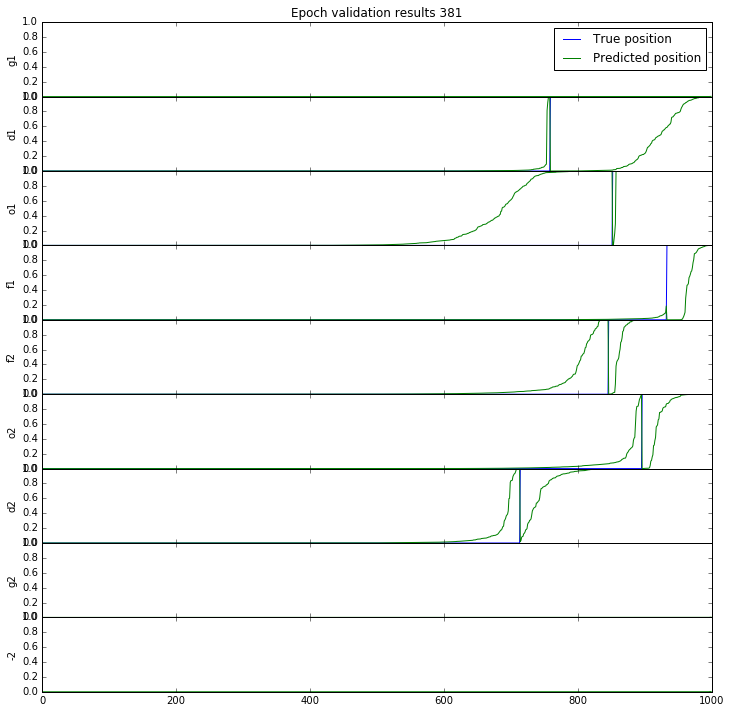

Wrote model to .\Models\weights_381.hdf
Epoch 382/382
176/175 [==============================] - 63s - loss: 0.0773 - categorical_accuracy: 0.9739 - val_loss: 0.9988 - val_categorical_accuracy: 0.7817
Wrote model to .\Models\weights_382.hdf
Epoch 383/383
176/175 [==============================] - 63s - loss: 0.0918 - categorical_accuracy: 0.9761 - val_loss: 0.8401 - val_categorical_accuracy: 0.8170
Wrote model to .\Models\weights_383.hdf
Epoch 384/384
176/175 [==============================] - 63s - loss: 0.0834 - categorical_accuracy: 0.9773 - val_loss: 1.0576 - val_categorical_accuracy: 0.7765
Wrote model to .\Models\weights_384.hdf
Epoch 385/385
176/175 [==============================] - 63s - loss: 0.1160 - categorical_accuracy: 0.9750 - val_loss: 1.5465 - val_categorical_accuracy: 0.7438
Wrote model to .\Models\weights_385.hdf
Epoch 386/386
176/175 [==============================] - 63s - loss: 0.0818 - categorical_accuracy: 0.9795 - val_loss: 0.9196 - val_categorical_accuracy: 0.

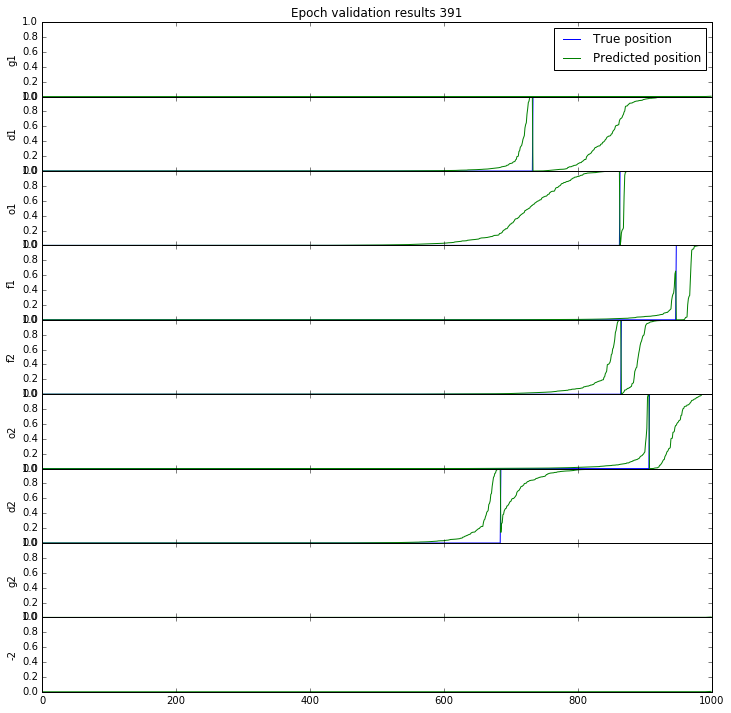

Wrote model to .\Models\weights_391.hdf
Epoch 392/392
176/175 [==============================] - 63s - loss: 0.1140 - categorical_accuracy: 0.9727 - val_loss: 0.9249 - val_categorical_accuracy: 0.7843
Wrote model to .\Models\weights_392.hdf
Epoch 393/393
176/175 [==============================] - 63s - loss: 0.0773 - categorical_accuracy: 0.9841 - val_loss: 1.6268 - val_categorical_accuracy: 0.7020
Wrote model to .\Models\weights_393.hdf
Epoch 394/394
176/175 [==============================] - 63s - loss: 0.1185 - categorical_accuracy: 0.9739 - val_loss: 1.2343 - val_categorical_accuracy: 0.7503
Wrote model to .\Models\weights_394.hdf
Epoch 395/395
176/175 [==============================] - 63s - loss: 0.0989 - categorical_accuracy: 0.9784 - val_loss: 0.5839 - val_categorical_accuracy: 0.8314
Wrote model to .\Models\weights_395.hdf
Epoch 396/396
176/175 [==============================] - 63s - loss: 0.0499 - categorical_accuracy: 0.9841 - val_loss: 1.7116 - val_categorical_accuracy: 0.

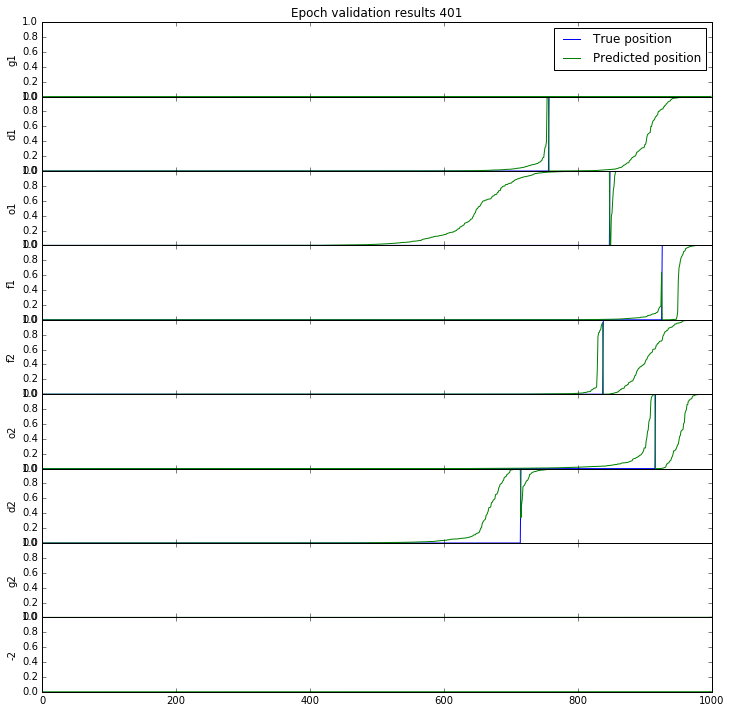

Wrote model to .\Models\weights_401.hdf
Epoch 402/402
176/175 [==============================] - 63s - loss: 0.0887 - categorical_accuracy: 0.9773 - val_loss: 0.8595 - val_categorical_accuracy: 0.7974
Wrote model to .\Models\weights_402.hdf
Epoch 403/403
176/175 [==============================] - 63s - loss: 0.0939 - categorical_accuracy: 0.9773 - val_loss: 1.0475 - val_categorical_accuracy: 0.7712
Wrote model to .\Models\weights_403.hdf
Epoch 404/404
176/175 [==============================] - 63s - loss: 0.0919 - categorical_accuracy: 0.9750 - val_loss: 1.2696 - val_categorical_accuracy: 0.7412
Wrote model to .\Models\weights_404.hdf
Epoch 405/405
176/175 [==============================] - 63s - loss: 0.0754 - categorical_accuracy: 0.9818 - val_loss: 2.2769 - val_categorical_accuracy: 0.6876
Wrote model to .\Models\weights_405.hdf
Epoch 406/406
176/175 [==============================] - 63s - loss: 0.0838 - categorical_accuracy: 0.9739 - val_loss: 1.1059 - val_categorical_accuracy: 0.

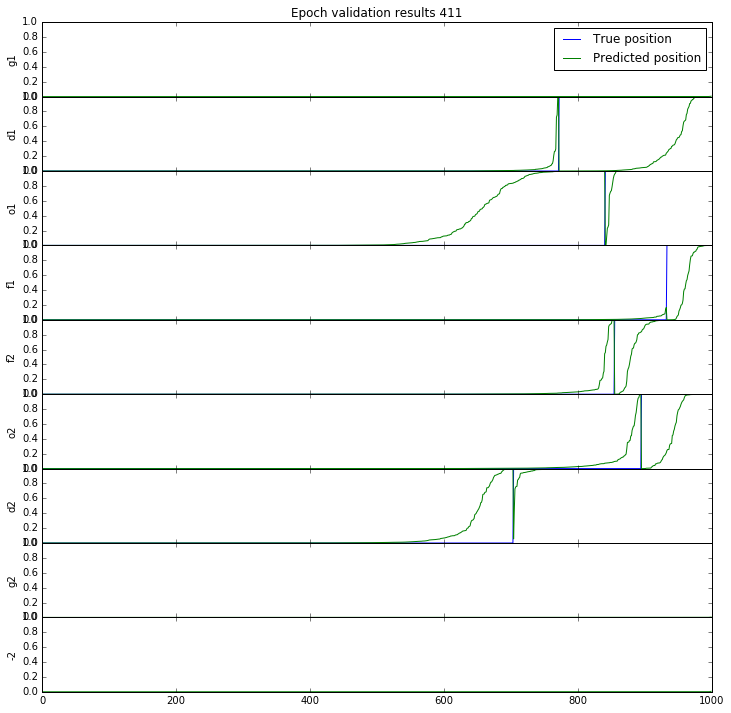

Wrote model to .\Models\weights_411.hdf
Epoch 412/412
176/175 [==============================] - 63s - loss: 0.0725 - categorical_accuracy: 0.9761 - val_loss: 1.2147 - val_categorical_accuracy: 0.7660
Wrote model to .\Models\weights_412.hdf
Epoch 413/413
176/175 [==============================] - 63s - loss: 0.1099 - categorical_accuracy: 0.9693 - val_loss: 1.0227 - val_categorical_accuracy: 0.7412
Wrote model to .\Models\weights_413.hdf
Epoch 414/414
176/175 [==============================] - 63s - loss: 0.0753 - categorical_accuracy: 0.9818 - val_loss: 1.3700 - val_categorical_accuracy: 0.7046
Wrote model to .\Models\weights_414.hdf
Epoch 415/415
176/175 [==============================] - 63s - loss: 0.0842 - categorical_accuracy: 0.9795 - val_loss: 1.2581 - val_categorical_accuracy: 0.7503
Wrote model to .\Models\weights_415.hdf
Epoch 416/416
176/175 [==============================] - 63s - loss: 0.1071 - categorical_accuracy: 0.9761 - val_loss: 0.9492 - val_categorical_accuracy: 0.

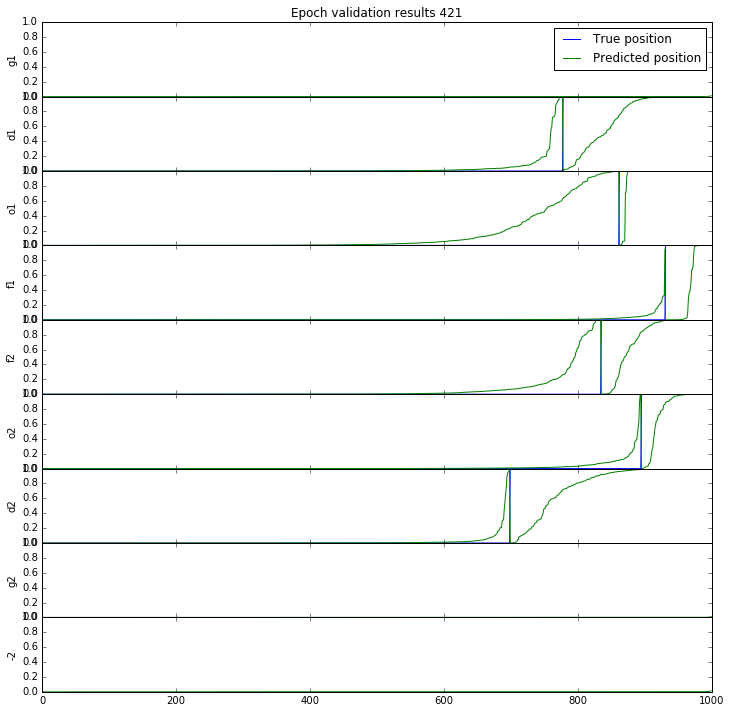

Wrote model to .\Models\weights_421.hdf
Epoch 422/422
176/175 [==============================] - 63s - loss: 0.1217 - categorical_accuracy: 0.9750 - val_loss: 0.6743 - val_categorical_accuracy: 0.8301
Wrote model to .\Models\weights_422.hdf
Epoch 423/423
176/175 [==============================] - 63s - loss: 0.1032 - categorical_accuracy: 0.9705 - val_loss: 0.8429 - val_categorical_accuracy: 0.8026
Wrote model to .\Models\weights_423.hdf
Epoch 424/424
176/175 [==============================] - 63s - loss: 0.0743 - categorical_accuracy: 0.9761 - val_loss: 0.7438 - val_categorical_accuracy: 0.8327
Wrote model to .\Models\weights_424.hdf
Epoch 425/425
176/175 [==============================] - 63s - loss: 0.0802 - categorical_accuracy: 0.9727 - val_loss: 1.1993 - val_categorical_accuracy: 0.7399
Wrote model to .\Models\weights_425.hdf
Epoch 426/426
176/175 [==============================] - 63s - loss: 0.0840 - categorical_accuracy: 0.9727 - val_loss: 1.0293 - val_categorical_accuracy: 0.

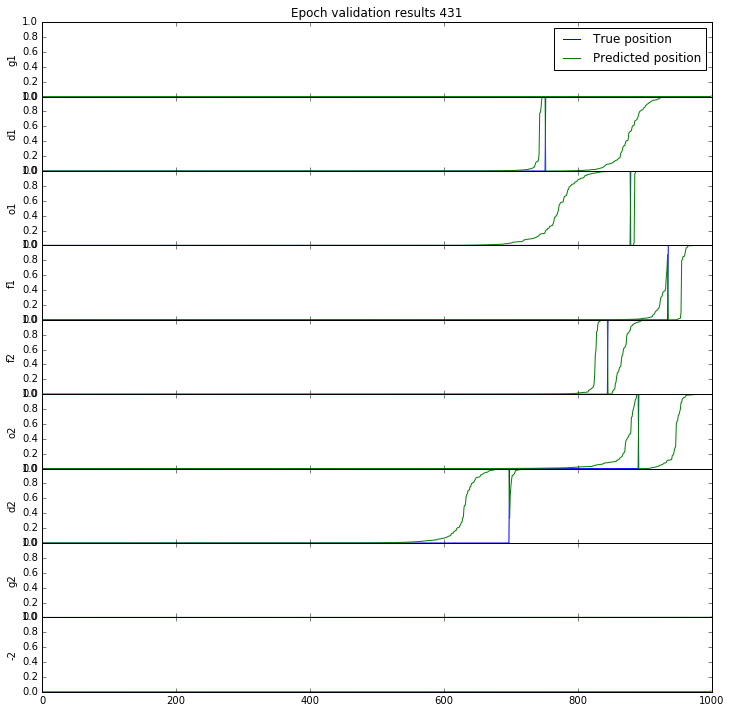

Wrote model to .\Models\weights_431.hdf
Epoch 432/432
176/175 [==============================] - 63s - loss: 0.0587 - categorical_accuracy: 0.9818 - val_loss: 1.0707 - val_categorical_accuracy: 0.7948
Wrote model to .\Models\weights_432.hdf
Epoch 433/433
176/175 [==============================] - 63s - loss: 0.0800 - categorical_accuracy: 0.9761 - val_loss: 1.3791 - val_categorical_accuracy: 0.7516
Wrote model to .\Models\weights_433.hdf
Epoch 434/434
176/175 [==============================] - 63s - loss: 0.0652 - categorical_accuracy: 0.9830 - val_loss: 1.8316 - val_categorical_accuracy: 0.7307
Wrote model to .\Models\weights_434.hdf
Epoch 435/435
176/175 [==============================] - 63s - loss: 0.1006 - categorical_accuracy: 0.9784 - val_loss: 1.3563 - val_categorical_accuracy: 0.7699
Wrote model to .\Models\weights_435.hdf
Epoch 436/436
176/175 [==============================] - 63s - loss: 0.1011 - categorical_accuracy: 0.9750 - val_loss: 1.3625 - val_categorical_accuracy: 0.

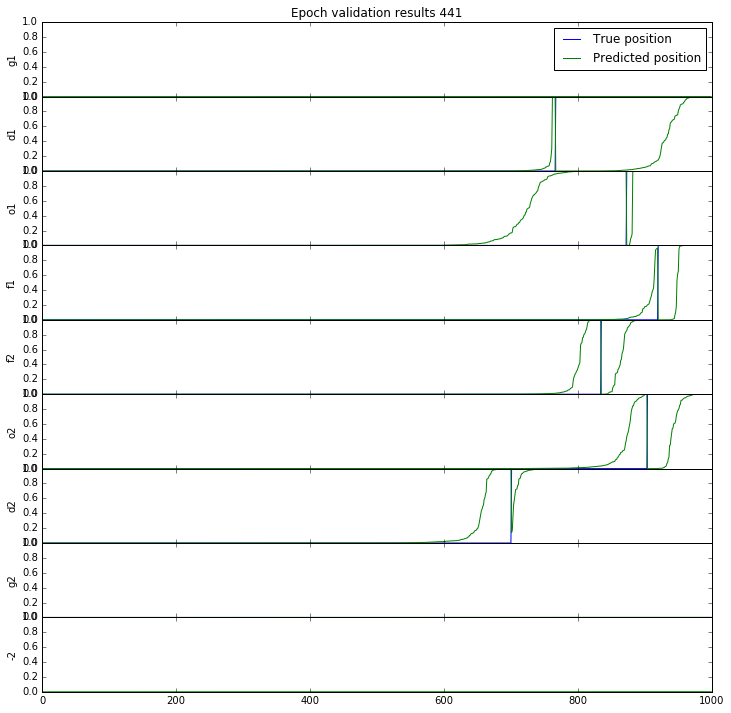

Wrote model to .\Models\weights_441.hdf
Epoch 442/442
176/175 [==============================] - 63s - loss: 0.0583 - categorical_accuracy: 0.9864 - val_loss: 2.1474 - val_categorical_accuracy: 0.7229
Wrote model to .\Models\weights_442.hdf
Epoch 443/443
176/175 [==============================] - 63s - loss: 0.0798 - categorical_accuracy: 0.9807 - val_loss: 3.1796 - val_categorical_accuracy: 0.6340
Wrote model to .\Models\weights_443.hdf
Epoch 444/444
176/175 [==============================] - 63s - loss: 0.1079 - categorical_accuracy: 0.9784 - val_loss: 1.3202 - val_categorical_accuracy: 0.7843
Wrote model to .\Models\weights_444.hdf
Epoch 445/445
176/175 [==============================] - 63s - loss: 0.0906 - categorical_accuracy: 0.9784 - val_loss: 1.3836 - val_categorical_accuracy: 0.7752
Wrote model to .\Models\weights_445.hdf
Epoch 446/446
176/175 [==============================] - 63s - loss: 0.0839 - categorical_accuracy: 0.9784 - val_loss: 1.2075 - val_categorical_accuracy: 0.

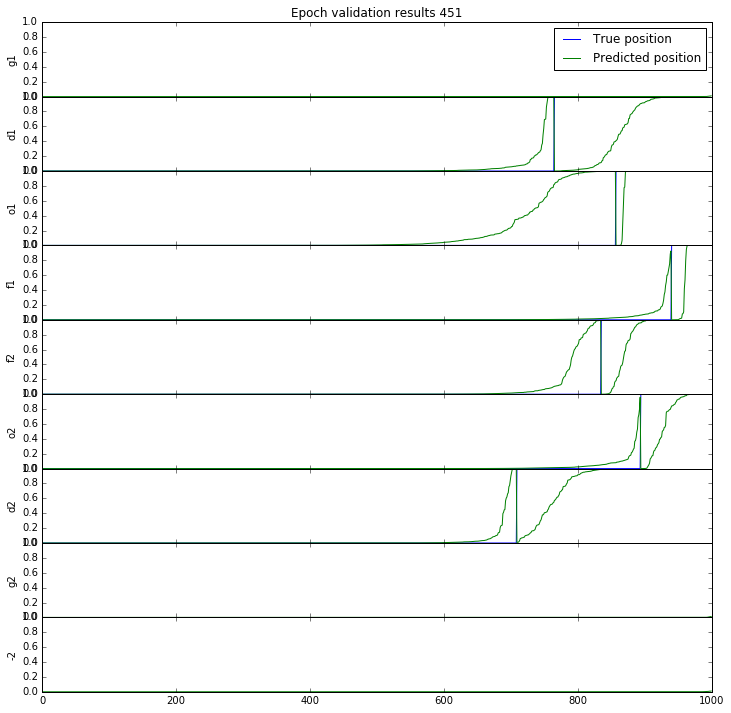

Wrote model to .\Models\weights_451.hdf
Epoch 452/452
176/175 [==============================] - 63s - loss: 0.0828 - categorical_accuracy: 0.9773 - val_loss: 1.9286 - val_categorical_accuracy: 0.6353
Wrote model to .\Models\weights_452.hdf
Epoch 453/453
176/175 [==============================] - 63s - loss: 0.1203 - categorical_accuracy: 0.9761 - val_loss: 0.6891 - val_categorical_accuracy: 0.8288
Wrote model to .\Models\weights_453.hdf
Epoch 454/454
176/175 [==============================] - 63s - loss: 0.0694 - categorical_accuracy: 0.9841 - val_loss: 1.1894 - val_categorical_accuracy: 0.7882
Wrote model to .\Models\weights_454.hdf
Epoch 455/455
176/175 [==============================] - 63s - loss: 0.0712 - categorical_accuracy: 0.9818 - val_loss: 1.5586 - val_categorical_accuracy: 0.7268
Wrote model to .\Models\weights_455.hdf
Epoch 456/456
176/175 [==============================] - 63s - loss: 0.0768 - categorical_accuracy: 0.9773 - val_loss: 0.9908 - val_categorical_accuracy: 0.

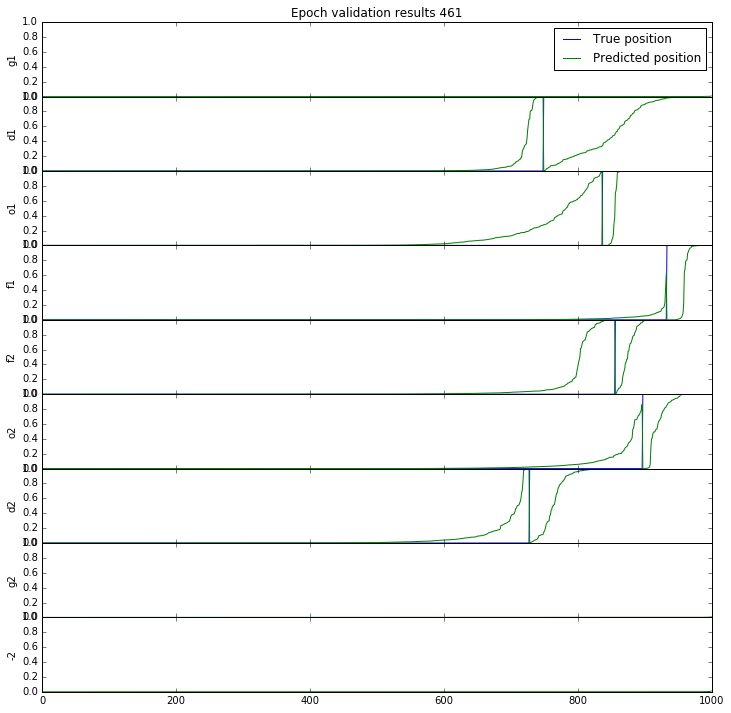

Wrote model to .\Models\weights_461.hdf
Epoch 462/462
176/175 [==============================] - 64s - loss: 0.0461 - categorical_accuracy: 0.9864 - val_loss: 1.5227 - val_categorical_accuracy: 0.7255
Wrote model to .\Models\weights_462.hdf
Epoch 463/463
176/175 [==============================] - 63s - loss: 0.0458 - categorical_accuracy: 0.9852 - val_loss: 1.6699 - val_categorical_accuracy: 0.7268
Wrote model to .\Models\weights_463.hdf
Epoch 464/464
176/175 [==============================] - 63s - loss: 0.1031 - categorical_accuracy: 0.9670 - val_loss: 0.6023 - val_categorical_accuracy: 0.8366
Wrote model to .\Models\weights_464.hdf
Epoch 465/465
176/175 [==============================] - 63s - loss: 0.0676 - categorical_accuracy: 0.9807 - val_loss: 0.8923 - val_categorical_accuracy: 0.7752
Wrote model to .\Models\weights_465.hdf
Epoch 466/466
176/175 [==============================] - 63s - loss: 0.0621 - categorical_accuracy: 0.9830 - val_loss: 1.1744 - val_categorical_accuracy: 0.

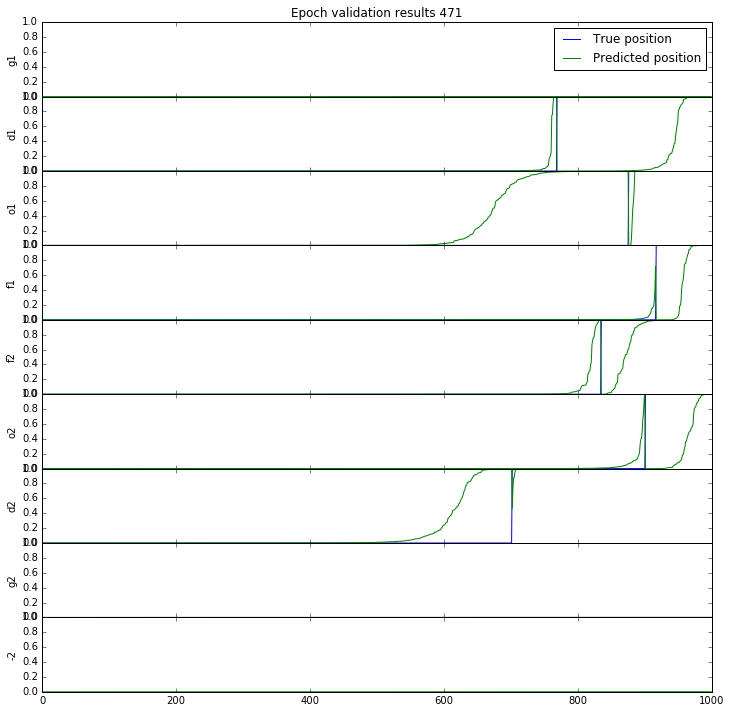

Wrote model to .\Models\weights_471.hdf
Epoch 472/472
176/175 [==============================] - 63s - loss: 0.0461 - categorical_accuracy: 0.9830 - val_loss: 2.6512 - val_categorical_accuracy: 0.6797
Wrote model to .\Models\weights_472.hdf
Epoch 473/473
176/175 [==============================] - 63s - loss: 0.1067 - categorical_accuracy: 0.9739 - val_loss: 1.1786 - val_categorical_accuracy: 0.7987
Wrote model to .\Models\weights_473.hdf
Epoch 474/474
176/175 [==============================] - 63s - loss: 0.1013 - categorical_accuracy: 0.9795 - val_loss: 1.1634 - val_categorical_accuracy: 0.7660
Wrote model to .\Models\weights_474.hdf
Epoch 475/475
176/175 [==============================] - 63s - loss: 0.0570 - categorical_accuracy: 0.9818 - val_loss: 1.6655 - val_categorical_accuracy: 0.7399
Wrote model to .\Models\weights_475.hdf
Epoch 476/476
176/175 [==============================] - 63s - loss: 0.0521 - categorical_accuracy: 0.9830 - val_loss: 1.4721 - val_categorical_accuracy: 0.

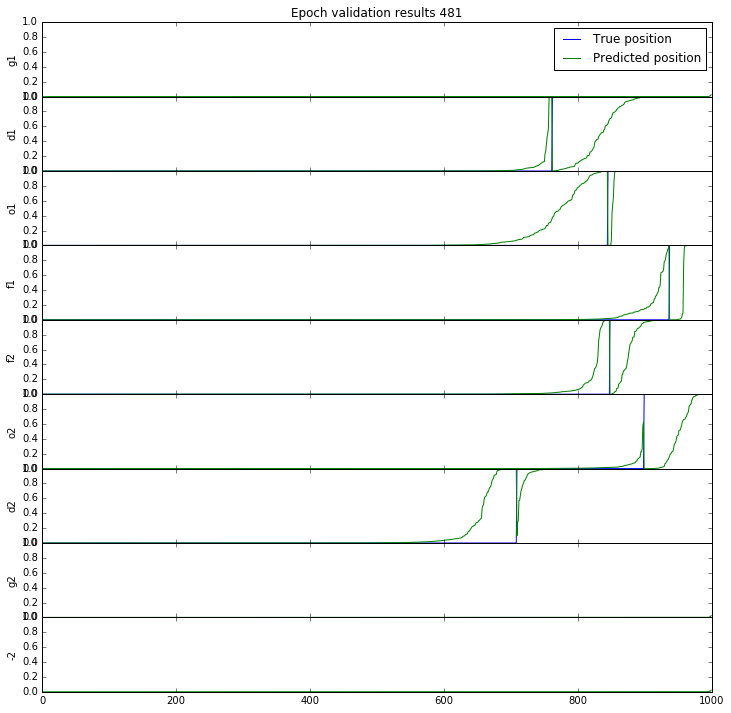

Wrote model to .\Models\weights_481.hdf
Epoch 482/482
176/175 [==============================] - 63s - loss: 0.0760 - categorical_accuracy: 0.9818 - val_loss: 1.6764 - val_categorical_accuracy: 0.7216
Wrote model to .\Models\weights_482.hdf
Epoch 483/483
176/175 [==============================] - 63s - loss: 0.0724 - categorical_accuracy: 0.9830 - val_loss: 0.8764 - val_categorical_accuracy: 0.8196
Wrote model to .\Models\weights_483.hdf
Epoch 484/484
176/175 [==============================] - 63s - loss: 0.0835 - categorical_accuracy: 0.9761 - val_loss: 1.1069 - val_categorical_accuracy: 0.7712
Wrote model to .\Models\weights_484.hdf
Epoch 485/485
176/175 [==============================] - 63s - loss: 0.0622 - categorical_accuracy: 0.9886 - val_loss: 1.1755 - val_categorical_accuracy: 0.8000
Wrote model to .\Models\weights_485.hdf
Epoch 486/486
176/175 [==============================] - 63s - loss: 0.0813 - categorical_accuracy: 0.9852 - val_loss: 0.9119 - val_categorical_accuracy: 0.

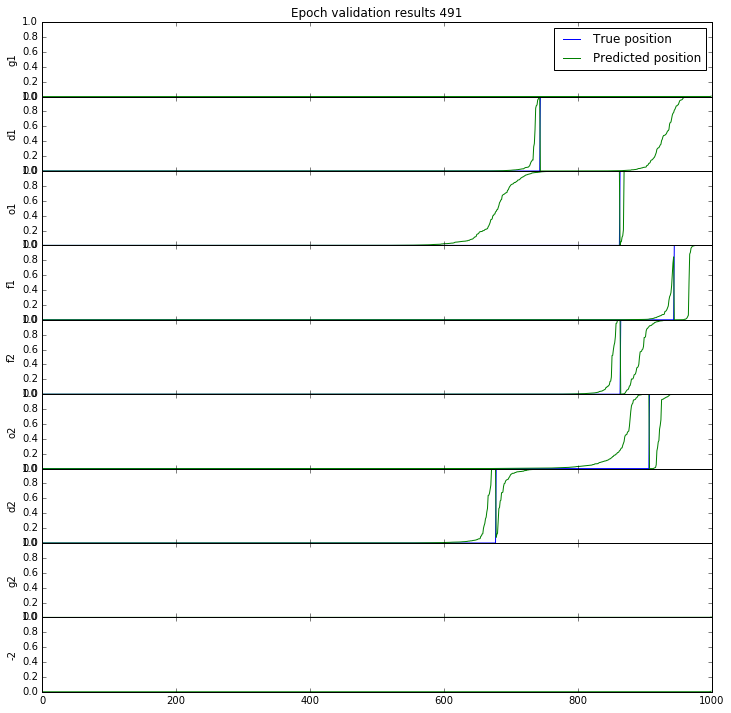

Wrote model to .\Models\weights_491.hdf
Epoch 492/492
176/175 [==============================] - 63s - loss: 0.0379 - categorical_accuracy: 0.9864 - val_loss: 1.7186 - val_categorical_accuracy: 0.7373
Wrote model to .\Models\weights_492.hdf
Epoch 493/493
176/175 [==============================] - 63s - loss: 0.1119 - categorical_accuracy: 0.9761 - val_loss: 1.9257 - val_categorical_accuracy: 0.7412
Wrote model to .\Models\weights_493.hdf
Epoch 494/494
176/175 [==============================] - 63s - loss: 0.0650 - categorical_accuracy: 0.9807 - val_loss: 1.5289 - val_categorical_accuracy: 0.7647
Wrote model to .\Models\weights_494.hdf
Epoch 495/495
176/175 [==============================] - 63s - loss: 0.0564 - categorical_accuracy: 0.9841 - val_loss: 0.8358 - val_categorical_accuracy: 0.8092
Wrote model to .\Models\weights_495.hdf
Epoch 496/496
176/175 [==============================] - 63s - loss: 0.1198 - categorical_accuracy: 0.9784 - val_loss: 1.2300 - val_categorical_accuracy: 0.

In [8]:
# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.00002),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 0
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 5
batches_training_per_epoch = int(training.length / batch_size) / 300
batches_validation_per_epoch = int(validation.length / batch_size) / 15
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
WEIGHTS_FNAME = '.\\Models\\weights_%i.hdf'
MODELS_FNAME = '.\\Models\\models_%i.h5'

for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), model, 1000, "Epoch validation results %i" % epoch, output_names)
    
    # Save the model
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)



Batch size 30: 1279 training batches, 319 validation batches
Epoch 144/144
1280/1279 [==============================] - 603s - loss: 0.6053 - categorical_accuracy: 0.7963 - val_loss: 0.1198 - val_categorical_accuracy: 0.9625


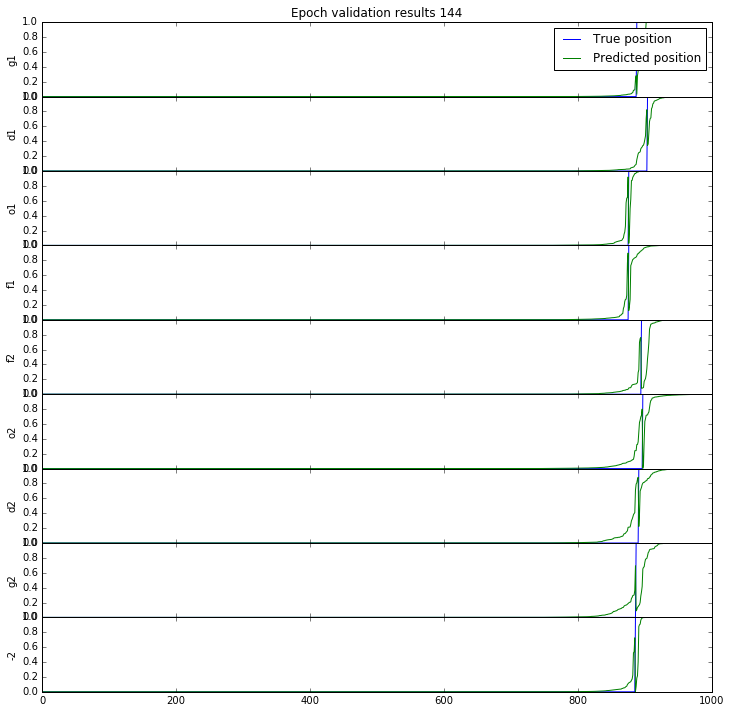

Wrote model to .\Models\weights_144.hdf
Epoch 145/145
1280/1279 [==============================] - 600s - loss: 0.6015 - categorical_accuracy: 0.8003 - val_loss: 0.1255 - val_categorical_accuracy: 0.9602
Wrote model to .\Models\weights_145.hdf
Epoch 146/146
1280/1279 [==============================] - 598s - loss: 0.6038 - categorical_accuracy: 0.7989 - val_loss: 0.1206 - val_categorical_accuracy: 0.9617
Wrote model to .\Models\weights_146.hdf
Epoch 147/147
1280/1279 [==============================] - 598s - loss: 0.6027 - categorical_accuracy: 0.7990 - val_loss: 0.1259 - val_categorical_accuracy: 0.9598
Wrote model to .\Models\weights_147.hdf
Epoch 148/148
1280/1279 [==============================] - 601s - loss: 0.5982 - categorical_accuracy: 0.8006 - val_loss: 0.1226 - val_categorical_accuracy: 0.9611
Wrote model to .\Models\weights_148.hdf
Epoch 149/149
1280/1279 [==============================] - 598s - loss: 0.5998 - categorical_accuracy: 0.8011 - val_loss: 0.1131 - val_categoric

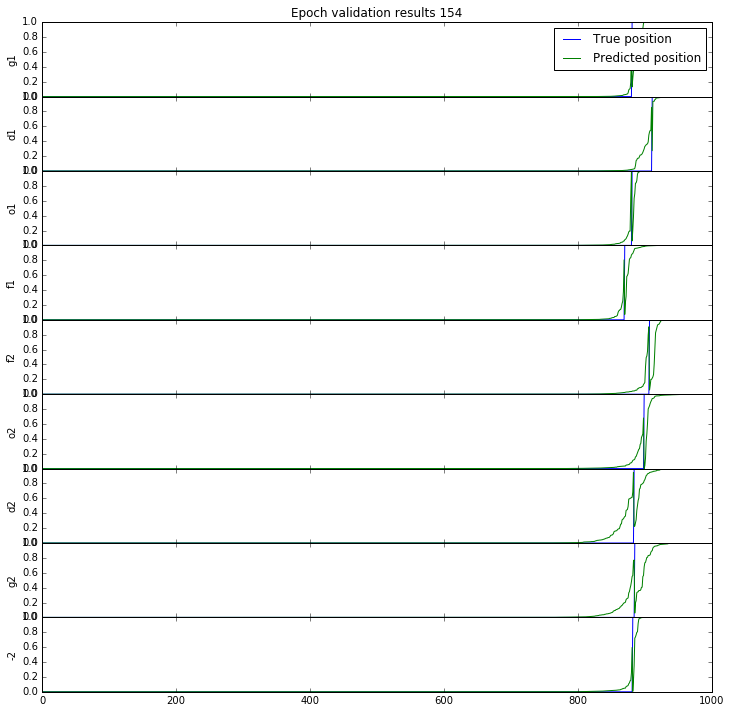

Wrote model to .\Models\weights_154.hdf
Epoch 155/155
1280/1279 [==============================] - 596s - loss: 0.5922 - categorical_accuracy: 0.8030 - val_loss: 0.1241 - val_categorical_accuracy: 0.9581
Wrote model to .\Models\weights_155.hdf
Epoch 156/156
1280/1279 [==============================] - 602s - loss: 0.6021 - categorical_accuracy: 0.7988 - val_loss: 0.1144 - val_categorical_accuracy: 0.9614
Wrote model to .\Models\weights_156.hdf
Epoch 157/157
1280/1279 [==============================] - 597s - loss: 0.5914 - categorical_accuracy: 0.8020 - val_loss: 0.1072 - val_categorical_accuracy: 0.9636
Wrote model to .\Models\weights_157.hdf
Epoch 158/158
1280/1279 [==============================] - 601s - loss: 0.5934 - categorical_accuracy: 0.8020 - val_loss: 0.1132 - val_categorical_accuracy: 0.9635
Wrote model to .\Models\weights_158.hdf
Epoch 159/159
1280/1279 [==============================] - 601s - loss: 0.5896 - categorical_accuracy: 0.8033 - val_loss: 0.1225 - val_categoric

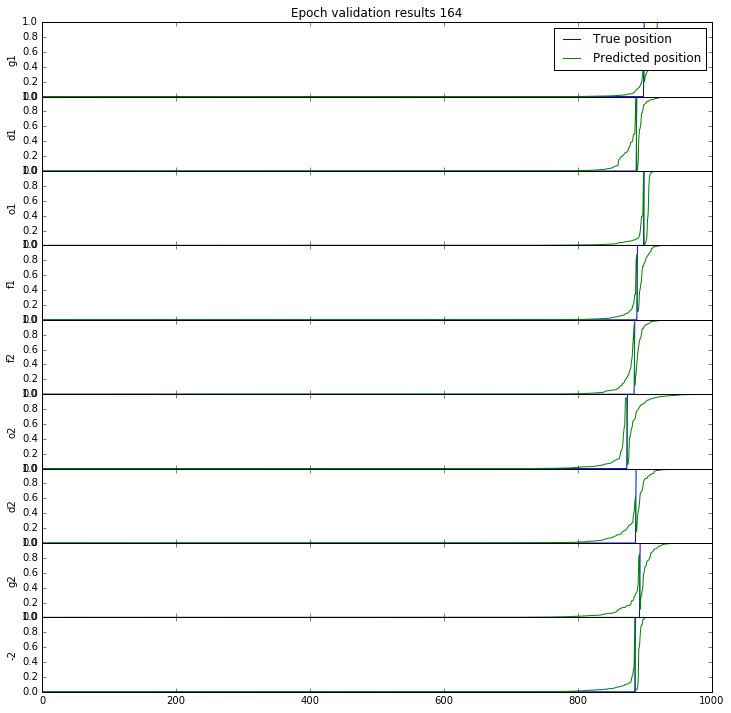

Wrote model to .\Models\weights_164.hdf
Epoch 165/165
1280/1279 [==============================] - 599s - loss: 0.5912 - categorical_accuracy: 0.8017 - val_loss: 0.1081 - val_categorical_accuracy: 0.9656
Wrote model to .\Models\weights_165.hdf
Epoch 166/166
1280/1279 [==============================] - 600s - loss: 0.5906 - categorical_accuracy: 0.8041 - val_loss: 0.1059 - val_categorical_accuracy: 0.9678
Wrote model to .\Models\weights_166.hdf
Epoch 167/167
1280/1279 [==============================] - 600s - loss: 0.5981 - categorical_accuracy: 0.8004 - val_loss: 0.1076 - val_categorical_accuracy: 0.9623
Wrote model to .\Models\weights_167.hdf
Epoch 168/168
1280/1279 [==============================] - 598s - loss: 0.5925 - categorical_accuracy: 0.8025 - val_loss: 0.1089 - val_categorical_accuracy: 0.9644
Wrote model to .\Models\weights_168.hdf
Epoch 169/169
1280/1279 [==============================] - 597s - loss: 0.5942 - categorical_accuracy: 0.8040 - val_loss: 0.1107 - val_categoric

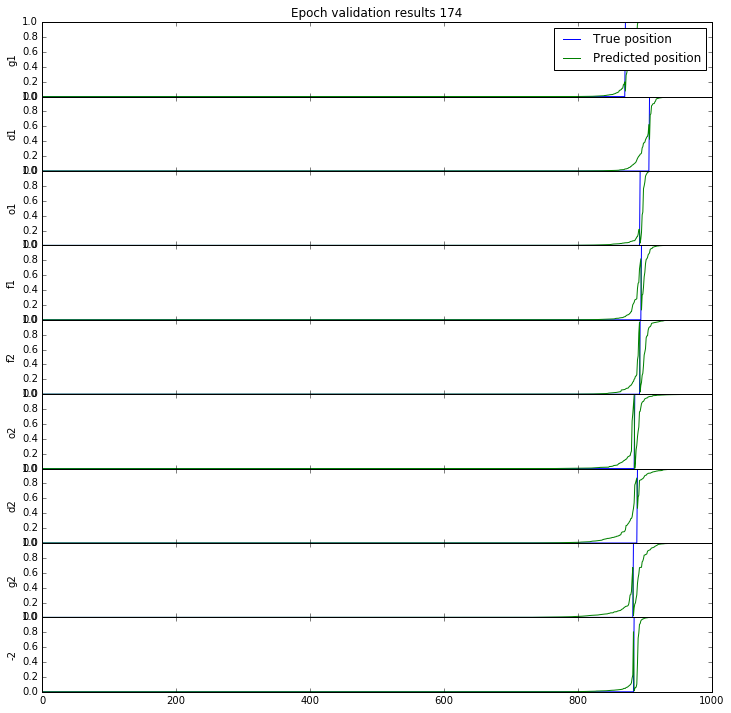

Wrote model to .\Models\weights_174.hdf
Epoch 175/175
1280/1279 [==============================] - 595s - loss: 0.5833 - categorical_accuracy: 0.8046 - val_loss: 0.1151 - val_categorical_accuracy: 0.9653
Wrote model to .\Models\weights_175.hdf
Epoch 176/176
1280/1279 [==============================] - 596s - loss: 0.5800 - categorical_accuracy: 0.8098 - val_loss: 0.1092 - val_categorical_accuracy: 0.9655
Wrote model to .\Models\weights_176.hdf
Epoch 177/177
1280/1279 [==============================] - 597s - loss: 0.5856 - categorical_accuracy: 0.8058 - val_loss: 0.1138 - val_categorical_accuracy: 0.9658
Wrote model to .\Models\weights_177.hdf
Epoch 178/178
1280/1279 [==============================] - 597s - loss: 0.5937 - categorical_accuracy: 0.8053 - val_loss: 0.1146 - val_categorical_accuracy: 0.9632
Wrote model to .\Models\weights_178.hdf
Epoch 179/179
1280/1279 [==============================] - 595s - loss: 0.5827 - categorical_accuracy: 0.8089 - val_loss: 0.1131 - val_categoric

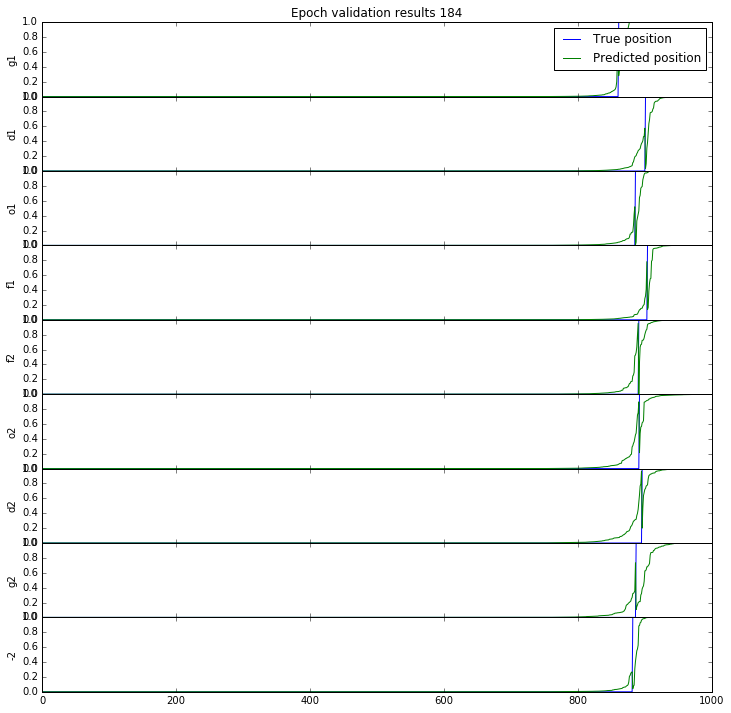

Wrote model to .\Models\weights_184.hdf
Epoch 185/185
1280/1279 [==============================] - 602s - loss: 0.5790 - categorical_accuracy: 0.8079 - val_loss: 0.1147 - val_categorical_accuracy: 0.9673
Wrote model to .\Models\weights_185.hdf
Epoch 186/186
1280/1279 [==============================] - 597s - loss: 0.5767 - categorical_accuracy: 0.8090 - val_loss: 0.1059 - val_categorical_accuracy: 0.9683
Wrote model to .\Models\weights_186.hdf
Epoch 187/187
1280/1279 [==============================] - 599s - loss: 0.5862 - categorical_accuracy: 0.8068 - val_loss: 0.1089 - val_categorical_accuracy: 0.9659
Wrote model to .\Models\weights_187.hdf
Epoch 188/188
1280/1279 [==============================] - 601s - loss: 0.5852 - categorical_accuracy: 0.8079 - val_loss: 0.1118 - val_categorical_accuracy: 0.9634
Wrote model to .\Models\weights_188.hdf
Epoch 189/189
1280/1279 [==============================] - 603s - loss: 0.5810 - categorical_accuracy: 0.8061 - val_loss: 0.1110 - val_categoric

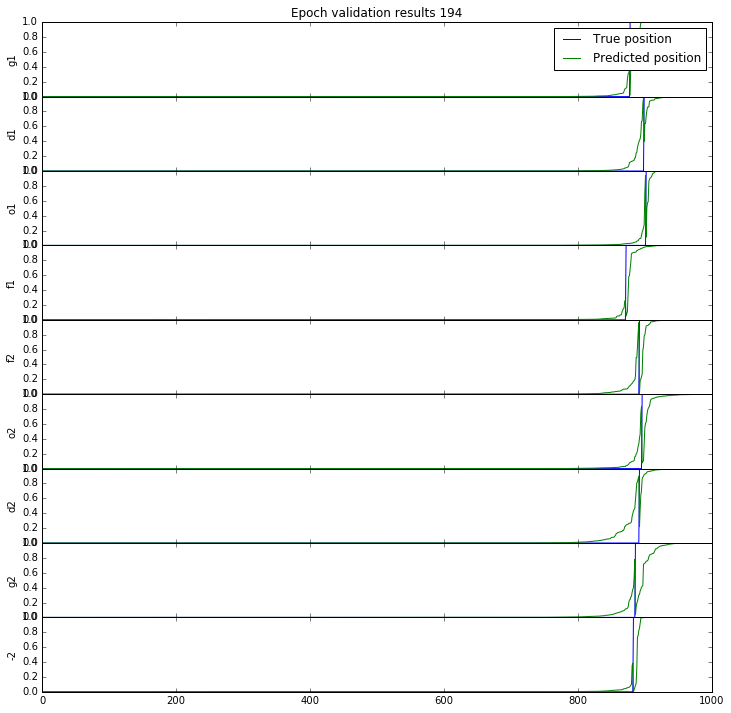

Wrote model to .\Models\weights_194.hdf
Epoch 195/195
1280/1279 [==============================] - 599s - loss: 0.5810 - categorical_accuracy: 0.8074 - val_loss: 0.1052 - val_categorical_accuracy: 0.9649
Wrote model to .\Models\weights_195.hdf
Epoch 196/196
1280/1279 [==============================] - 598s - loss: 0.5752 - categorical_accuracy: 0.8096 - val_loss: 0.1179 - val_categorical_accuracy: 0.9645
Wrote model to .\Models\weights_196.hdf
Epoch 197/197
1280/1279 [==============================] - 598s - loss: 0.5890 - categorical_accuracy: 0.8072 - val_loss: 0.1070 - val_categorical_accuracy: 0.9686
Wrote model to .\Models\weights_197.hdf
Epoch 198/198
1280/1279 [==============================] - 603s - loss: 0.5834 - categorical_accuracy: 0.8071 - val_loss: 0.1213 - val_categorical_accuracy: 0.9639
Wrote model to .\Models\weights_198.hdf
Epoch 199/199
1280/1279 [==============================] - 601s - loss: 0.5693 - categorical_accuracy: 0.8135 - val_loss: 0.1070 - val_categoric

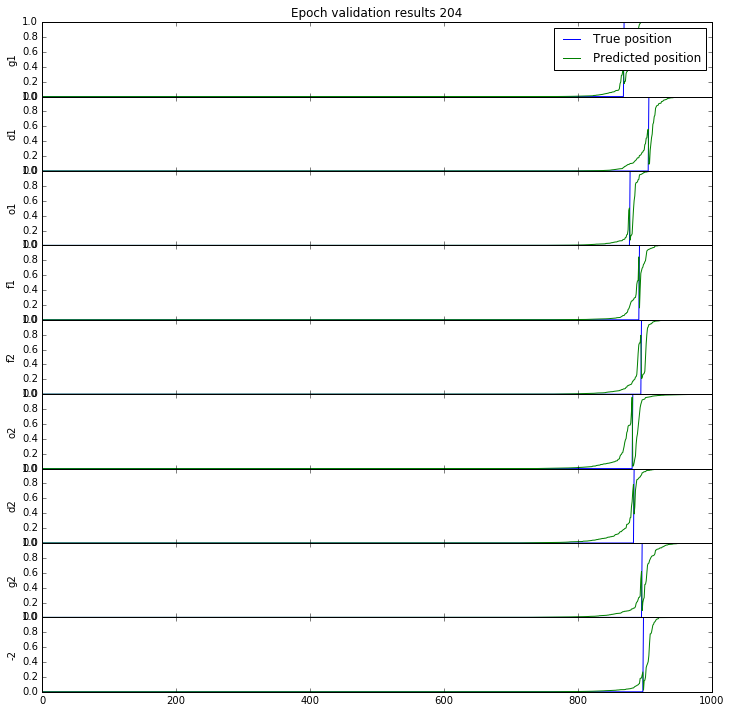

Wrote model to .\Models\weights_204.hdf
Epoch 205/205
1280/1279 [==============================] - 597s - loss: 0.5704 - categorical_accuracy: 0.8115 - val_loss: 0.1085 - val_categorical_accuracy: 0.9668
Wrote model to .\Models\weights_205.hdf
Epoch 206/206
1280/1279 [==============================] - 598s - loss: 0.5759 - categorical_accuracy: 0.8102 - val_loss: 0.1049 - val_categorical_accuracy: 0.9670
Wrote model to .\Models\weights_206.hdf
Epoch 207/207
1280/1279 [==============================] - 599s - loss: 0.5714 - categorical_accuracy: 0.8130 - val_loss: 0.1083 - val_categorical_accuracy: 0.9644
Wrote model to .\Models\weights_207.hdf
Epoch 208/208
 562/1279 [============>.................] - ETA: 312s - loss: 0.5738 - categorical_accuracy: 0.8079

KeyboardInterrupt: 

In [9]:
# For a multi-class classification problem
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.000005),
#model.compile(optimizer=keras.optimizers.adam(),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Was ran on the above simple model, not pre-trained Inceptionv3 run.
epoch = 143
#batches_validation_per_epoch = 50
#batches_training_per_epoch = 400
batch_size = 30
batches_training_per_epoch = int(training.length / batch_size) / 5
batches_validation_per_epoch = int(validation.length / batch_size) / 5
print("Batch size %i: %i training batches, %i validation batches" % (batch_size, batches_training_per_epoch, batches_validation_per_epoch) )
WEIGHTS_FNAME = '.\\Models\\weights_%i.hdf'
MODELS_FNAME = '.\\Models\\models_%i.h5'

for i in range(500):
    model.fit_generator(
        TrainBatchGen(batch_size, training=training),
        batches_training_per_epoch,
        epochs=epoch+1,
        verbose=1,
        callbacks=None,
        class_weight=None,
        max_q_size=50,
        workers=50,
        validation_data=ValidationBatchGen(batch_size, validation),
        validation_steps = batches_validation_per_epoch,
        pickle_safe=False,
        initial_epoch=epoch)
    
    epoch += 1
    
    # Plot occasional validation data plot
    if i % 10 == 0:
        plot_validate(ValidationBatchGen(batch_size, validation), model, 1000, "Epoch validation results %i" % epoch, output_names)
    
    # Save the model
    model.save_weights(WEIGHTS_FNAME % epoch)
    model.save(MODELS_FNAME % epoch)
    print(("Wrote model to " + WEIGHTS_FNAME )  % epoch)

